# Projet 4 - Anticipez les besoins en consommation de bâtiments - SEATTLE

## Librairies

In [1]:
import re
import sys
import sklearn
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import missingno as msno
import scipy.stats as stat
import matplotlib.pyplot as plt
from sklearn.preprocessing import Binarizer

from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

In [2]:
data_2016 = pd.read_csv('../Source/2016_Building_Energy_Benchmarking.csv', sep=',', encoding='UTF-8')

In [3]:
data_2016.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [4]:
# dimensions
print(f"Il y a {data_2016.shape[0]} lignes et {data_2016.shape[1]} colonnes dans le jeu de donnees.")

Il y a 3376 lignes et 46 colonnes dans le jeu de donnees.


In [5]:
# types des variables
data_2016.dtypes

OSEBuildingID                        int64
DataYear                             int64
BuildingType                        object
PrimaryPropertyType                 object
PropertyName                        object
Address                             object
City                                object
State                               object
ZipCode                            float64
TaxParcelIdentificationNumber       object
CouncilDistrictCode                  int64
Neighborhood                        object
Latitude                           float64
Longitude                          float64
YearBuilt                            int64
NumberofBuildings                  float64
NumberofFloors                       int64
PropertyGFATotal                     int64
PropertyGFAParking                   int64
PropertyGFABuilding(s)               int64
ListOfAllPropertyUseTypes           object
LargestPropertyUseType              object
LargestPropertyUseTypeGFA          float64
SecondLarge

In [6]:
data_2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [7]:
# statistiques var quantitatives
data_2016.describe()

,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,...,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Comments,TotalGHGEmissions,GHGEmissionsIntensity
count,3376.000000,3376.0,3360.000000,3376.000000,3376.000000,3376.000000,3376.000000,3368.000000,3376.000000,3.376000e+03,...,3.371000e+03,3.370000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,0.0,3367.000000,3367.000000
mean,21208.991114,2016.0,98116.949107,4.439277,47.624033,-122.334795,1968.573164,1.106888,4.709123,9.483354e+04,...,5.403667e+06,5.276726e+06,2.745959e+05,1.086639e+06,3.707612e+06,1.368505e+04,1.368505e+06,NaN,119.723971,1.175916
std,12223.757015,0.0,18.615205,2.120625,0.047758,0.027203,33.088156,2.108402,5.494465,2.188376e+05,...,2.161063e+07,1.593879e+07,3.912173e+06,4.352478e+06,1.485066e+07,6.709781e+04,6.709781e+06,NaN,538.832227,1.821452
min,1.000000,2016.0,98006.000000,1.000000,47.499170,-122.414250,1900.000000,0.000000,0.000000,1.128500e+04,...,0.000000e+00,0.000000e+00,0.000000e+00,-3.382680e+04,-1.154170e+05,0.000000e+00,0.000000e+00,NaN,-0.800000,-0.020000
25%,19990.750000,2016.0,98105.000000,3.000000,47.599860,-122.350662,1948.000000,1.000000,2.000000,2.848700e+04,...,9.251286e+05,9.701822e+05,0.000000e+00,1.874229e+05,6.394870e+05,0.000000e+00,0.000000e+00,NaN,9.495000,0.210000
50%,23112.000000,2016.0,98115.000000,4.000000,47.618675,-122.332495,1975.000000,1.000000,4.000000,4.417500e+04,...,1.803753e+06,1.904452e+06,0.000000e+00,3.451299e+05,1.177583e+06,3.237538e+03,3.237540e+05,NaN,33.920000,0.610000
75%,25994.250000,2016.0,98122.000000,7.000000,47.657115,-122.319407,1997.000000,1.000000,5.000000,9.099200e+04,...,4.222455e+06,4.381429e+06,0.000000e+00,8.293178e+05,2.829632e+06,1.189033e+04,1.189034e+06,NaN,93.940000,1.370000
max,50226.000000,2016.0,98272.000000,7.000000,47.733870,-122.220966,2015.000000,111.000000,99.000000,9.320156e+06,...,8.739237e+08,4.716139e+08,1.349435e+08,1.925775e+08,6.570744e+08,2.979090e+06,2.979090e+08,NaN,16870.980000,34.090000


In [8]:
# statistiques var qualitatives
data_2016.describe(exclude=[np.number])

,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,TaxParcelIdentificationNumber,Neighborhood,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,YearsENERGYSTARCertified,DefaultData,ComplianceStatus,Outlier
count,3376,3376,3376,3376,3376,3376,3376,3376,3367,3356,1679,596,119,3376,3376,32
unique,8,24,3362,3354,1,1,3268,19,466,56,50,44,65,2,4,2
top,NonResidential,Low-Rise Multifamily,Northgate Plaza,2600 SW Barton St,Seattle,WA,1625049001,DOWNTOWN,Multifamily Housing,Multifamily Housing,Parking,Retail Store,2016,False,Compliant,Low outlier
freq,1460,987,3,4,3376,3376,8,573,866,1667,976,110,14,3263,3211,23


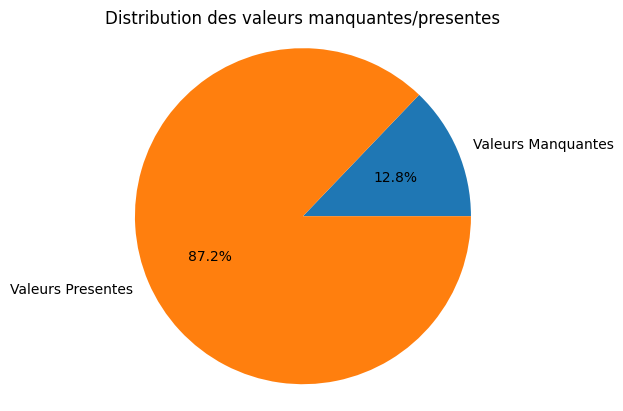

In [9]:
# Valeurs manquantes
null_values_sum = data_2016.isnull().sum().sum()
notnull_values_sum = data_2016.notnull().sum().sum()

fig, ax = plt.subplots()
ax.pie([null_values_sum, notnull_values_sum], labels=['Valeurs Manquantes', 'Valeurs Presentes'], autopct='%1.1f%%')
ax.axis('equal')  # affirme que le graph est un cercle
ax.set_title('Distribution des valeurs manquantes/presentes')
plt.show()

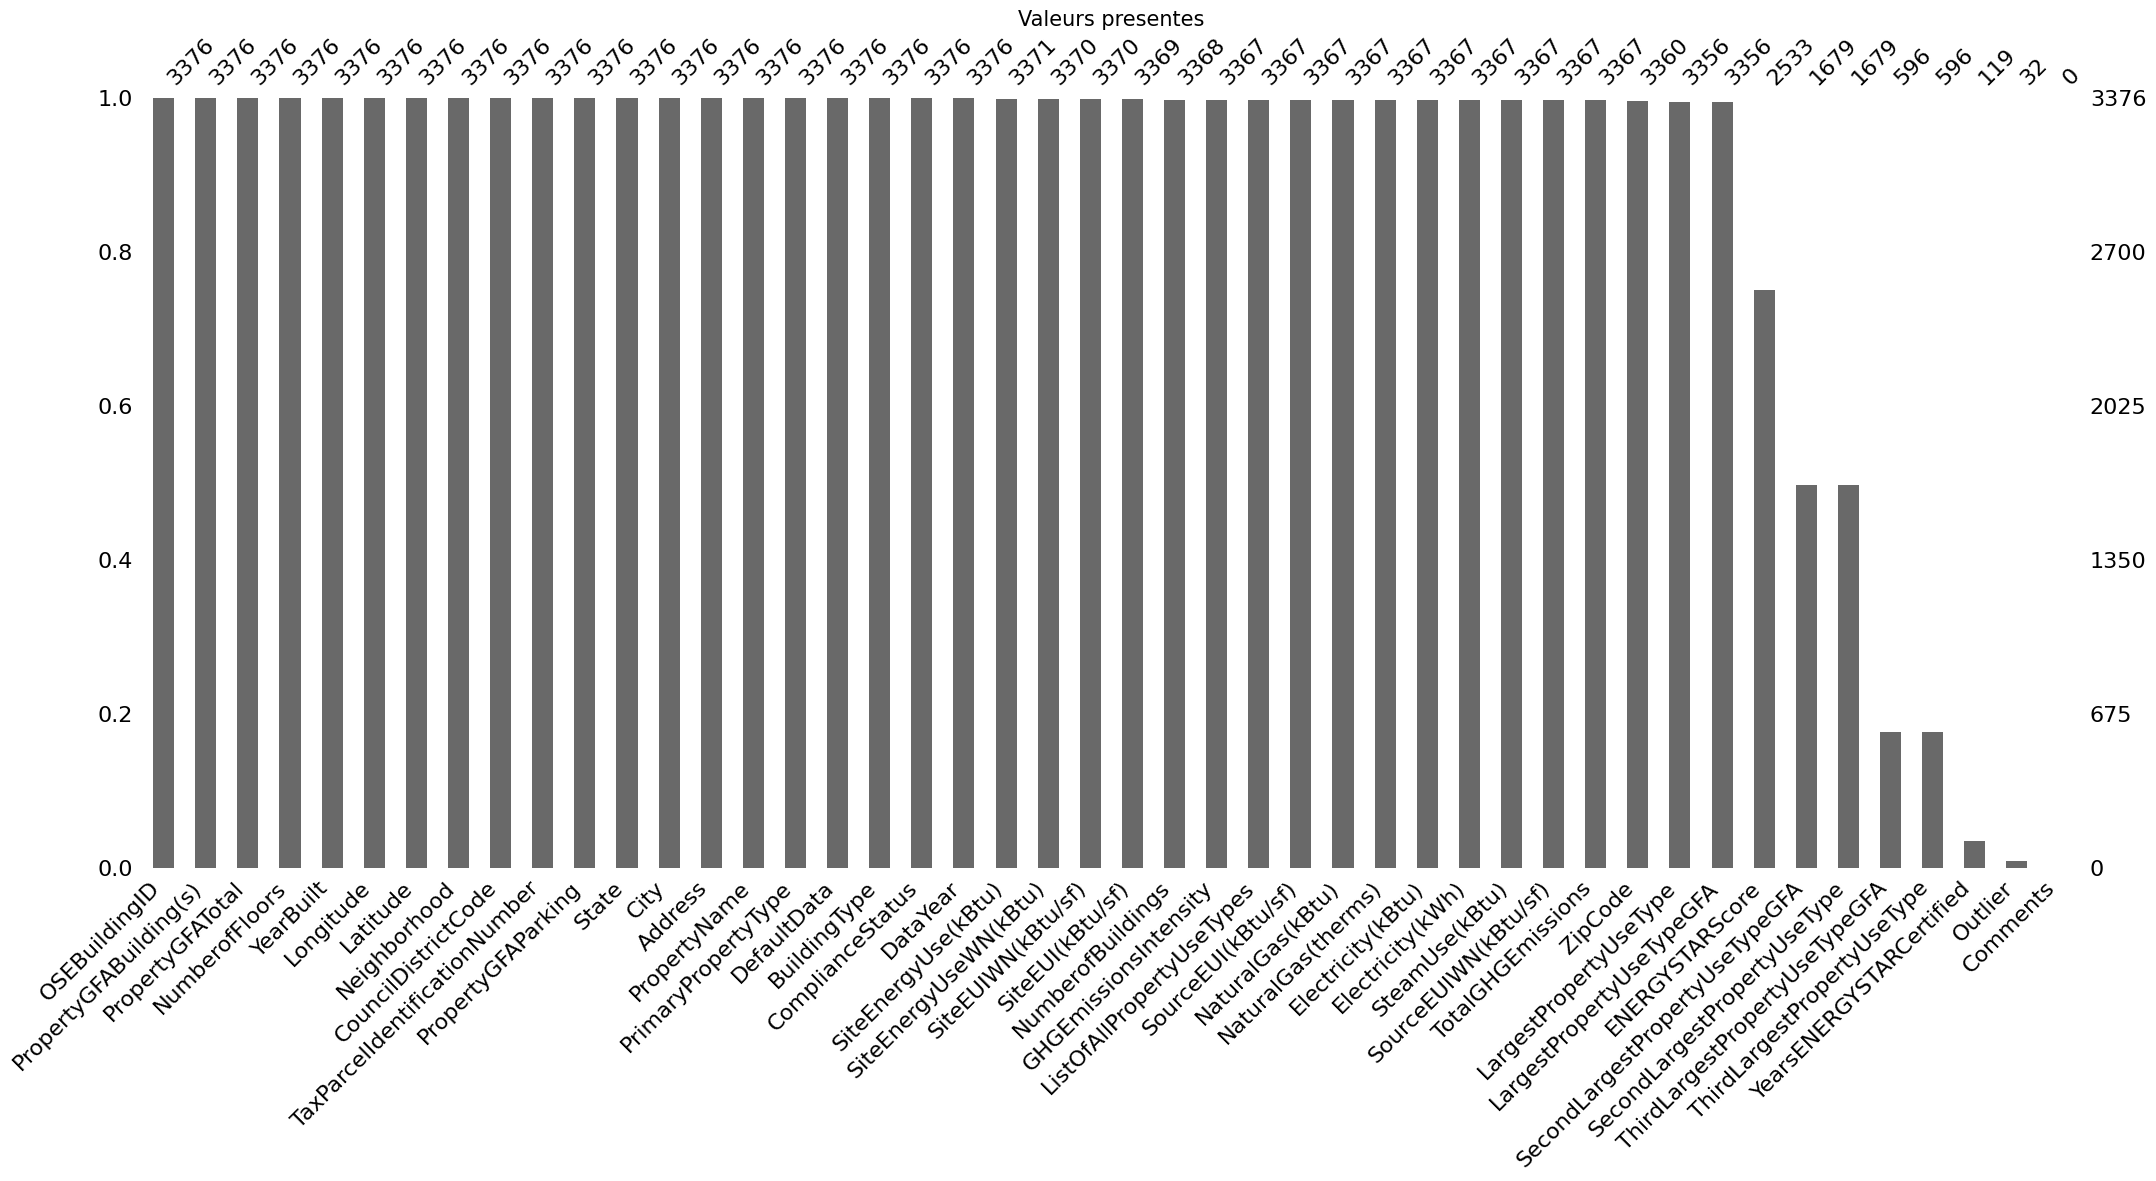

In [10]:
# Visualisation des valeurs manquantes
barcahrt = msno.bar(data_2016, sort="descending")
barcahrt.set_title("Valeurs presentes", fontsize=15)
plt.show()

In [11]:
# Copie du dataframe initiale, retrait des informations non voulu
build_df = data_2016.copy()

col_to_remove = []

print(build_df.columns)

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus',
       'Outlier

## Building ID

In [12]:
# Check des doublons dans les building ID
duplicates = build_df.duplicated(subset=['OSEBuildingID'])
print(str(build_df[duplicates].size) + " doublons presents dans la colonne OSEBuildingID.")

0 doublons presents dans la colonne OSEBuildingID.


In [13]:
col_to_remove.append('OSEBuildingID')

## Building Name

In [14]:
# Nom des building est donne par la var PropertyName
display(build_df['PropertyName'].describe())

count                3376
unique               3362
top       Northgate Plaza
freq                    3
Name: PropertyName, dtype: object

##### Pas d'informations pertinentes, retrait de la colonne

In [15]:
col_to_remove.append('PropertyName')

## Building Type

B̲u̲i̲l̲d̲i̲n̲g̲T̲y̲p̲e


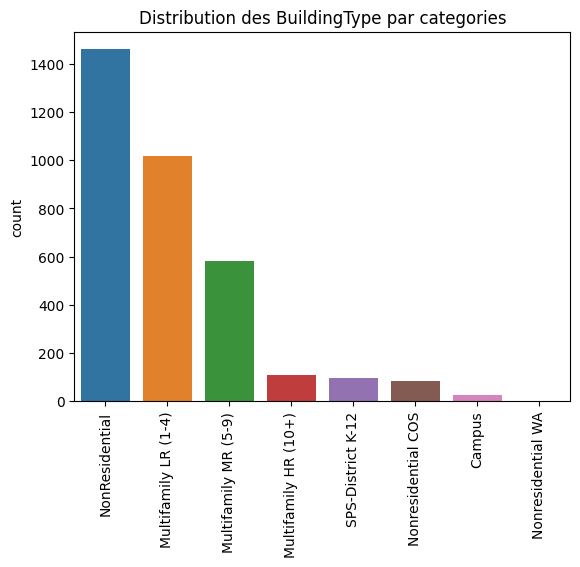

P̲r̲i̲m̲a̲r̲y̲P̲r̲o̲p̲e̲r̲t̲y̲T̲y̲p̲e
                             count
PrimaryPropertyType               
Low-Rise Multifamily           987
Mid-Rise Multifamily           564
Small- and Mid-Sized Office    293
Other                          256
Warehouse                      187
Large Office                   173
K-12 School                    139
Mixed Use Property             133
High-Rise Multifamily          105
Retail Store                    91
Hotel                           77
Worship Facility                71
Distribution Center             53
Senior Care Community           45
Supermarket / Grocery Store     40
Medical Office                  39
Self-Storage Facility           28
University                      25
Residence Hall                  23
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Office                           3
L̲a̲r̲g̲e̲s̲t̲P̲r̲o̲p̲e̲r̲t̲y̲U̲s̲e̲T̲y̲p̲e
        

In [16]:
# Définir le type de bâtiment
building_type_col = ['BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']

for col in building_type_col:

    print('\u0332'.join(col))

    if build_df[col].nunique() > 10:
        print(build_df[col].value_counts().to_frame()) # affiche le texte s'il y a trop de catégories
    else:
        countplot = sns.countplot(x=col, data=build_df, order=build_df[col].sort_values().value_counts().index)
        plt.xticks(rotation = 90)
        plt.title("Distribution des " + col + " par categories")
        plt.xlabel("")
        plt.show()

print("\n\n")

##### Beaucoup de categories presentes. creations de nouvelles categories pour les regrouper.

In [17]:
# Creation d'un dictionnaire avec les nouvelles categories
building_type_dict = {
    'Residential': ['Low-Rise Multifamily', 'Mid-Rise Multifamily', 'High-Rise Multifamily', 'Senior Care Community',
                    'Residence Hall', 'Multifamily Housing', 'Residence Hall/Dormitory', 'Other - Lodging/Residential', 
                    'Residential Care Facility'],

    'Office': ['Small- and Mid-Sized Office', 'Large Office', 'Office', 'Financial Office', 'Bank Branch'],
    
    'Education': ['K-12 School', 'University', 'College/University', 'Other - Education', 'Adult Education', 
                  'Pre-school/Daycare', 'Vocational School'],

    'Stores': ['Retail Store', 'Supermarket/Grocery Store', 'Supermarket / Grocery Store', 'Repair Services (Vehicle, Shoe, Locksmith, etc)',
               'Strip Mall', 'Automobile Dealership', 'Other - Services', 'Other - Mall', 'Wholesale Club/Supercenter', 
               'Enclosed Mall', 'Convenience Store without Gas Station'],

    'Culture': ['Other - Recreation', 'Other - Entertainment/Public Assembly', 'Social/Meeting Hall', 'Museum',
                'Fitness Center/Health Club/Gym', 'Library', 'Performing Arts', 'Lifestyle Center', 'Convention Center',
                'Movie Theater', 'Personal Services (Health/Beauty, Dry Cleaning, etc)', 'Swimming Pool'],

    'Services': ['Parking', 'Prison/Incarceration', 'Other - Public Services', 'Fire Station', 'Police Station', 'Courthouse'],

    'Industrial': ['Warehouse', 'Distribution Center', 'Self-Storage Facility', 'Refrigerated Warehouse', 
                   'Non-Refrigerated Warehouse', 'Manufacturing/Industrial Plant', 'Data Center', 'Other - Technology/Science'],

    'Healthcare': ['Medical Office', 'Hospital', 'Laboratory', 'Hospital (General Medical & Surgical)', 
                   'Urgent Care/Clinic/Other Outpatient', 'Other/Specialty Hospital'],

    'Religion': ['Worship Facility'],

    'Hotel': ['Hotel'],

    'Restaurant': ['Restaurant', 'Other - Restaurant/Bar', 'Food Service', 'Bar/Nightclub', 'Food Sales', 'Fast Food Restaurant'],
    
    'Other': ['Other', 'Mixed Use Property', 'Other - Utility']
}

In [18]:
def type_to_new_category(current_type, **dictionary):
  new_type = 'NOT_FOUND'

  if (type(current_type) == int) or (type(current_type) == float):
    new_type = 'Other'

  else:
    for dict_type, dict_type_list in dictionary.items():
      if current_type in dict_type_list:
        new_type = dict_type
        break

  return new_type

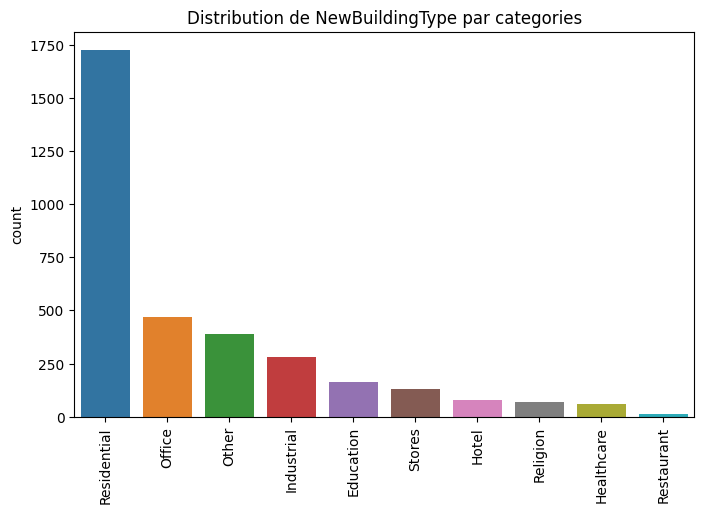

In [19]:
# Nouvelle colonne
new_type_col = 'NewBuildingType'

# Ajout d'une nouvelle categorie dans la nmouvelle colonne
build_df[new_type_col] = build_df['PrimaryPropertyType'].apply(type_to_new_category, **building_type_dict)

# Affiche la nouvelle colonne
plt.figure(figsize=(8,5))
countplot = sns.countplot(x=new_type_col, data=build_df, order=build_df[new_type_col].sort_values().value_counts().index)
plt.xticks(rotation = 90)
plt.title("Distribution de " + new_type_col + " par categories")
plt.xlabel("")
plt.show()

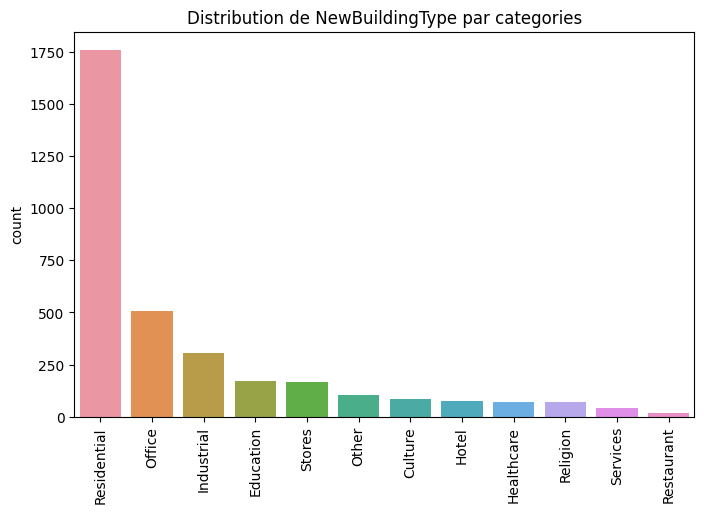

In [20]:
# Recuperation de la categorie Other building uniquement
other_index = build_df[build_df[new_type_col] == 'Other'].index

# On applique la fonction
build_df.loc[other_index, new_type_col] = build_df.loc[other_index, 'LargestPropertyUseType'].apply(type_to_new_category, **building_type_dict)

# Affichage de la nouvelle colonne
plt.figure(figsize=(8,5))
countplot = sns.countplot(x=new_type_col, data=build_df, order=build_df[new_type_col].sort_values().value_counts().index)
plt.xticks(rotation = 90)
plt.title("Distribution de " + new_type_col + " par categories")
plt.xlabel("")
plt.show()

##### L'etude porte sur les building non residentiel. Je vais donc les retirer

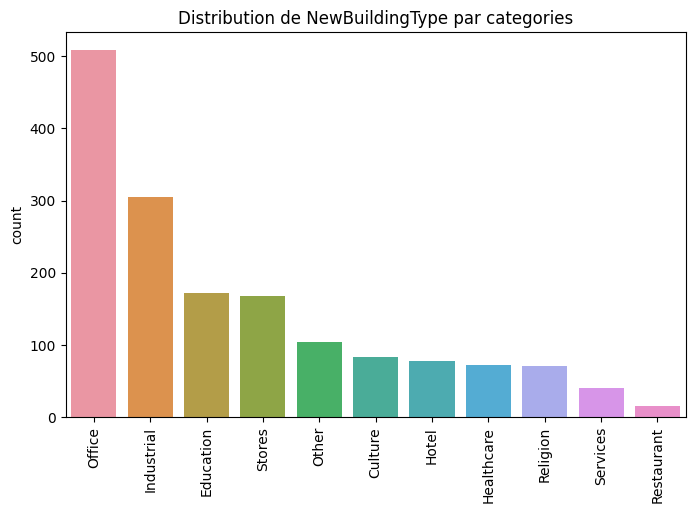

In [21]:
# Retrait des building residentiels
build_df = build_df.loc[~(build_df[new_type_col] == 'Residential')]

plt.figure(figsize=(8,5))
countplot = sns.countplot(x=new_type_col, data=build_df, order=build_df[new_type_col].sort_values().value_counts().index)
plt.xticks(rotation = 90)
plt.title("Distribution de " + new_type_col + " par categories")
plt.xlabel("")
plt.show()

In [22]:
# Nombre de building non residentiel
nonres_n = build_df.loc[build_df['BuildingType'].str.contains('nonresidential', flags=re.IGNORECASE)].size
print(f"{(nonres_n/build_df.size)*100} % des building sont 'NonResidential'.")

91.9035846724351 % des building sont 'NonResidential'.


In [23]:
col_to_remove.extend(building_type_col)

## Building localization

In [24]:
# Colonnes avec les infos des Building
building_adress_columns = ['Address', 'City', 'State', 'ZipCode', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood', 'Longitude', 'Latitude']

for col in building_adress_columns:
  display(build_df[col].describe())
  print("\n")

count                  1618
unique                 1598
top       2600 SW Barton St
freq                      4
Name: Address, dtype: object

count        1618
unique          1
top       Seattle
freq         1618
Name: City, dtype: object

count     1618
unique       1
top         WA
freq      1618
Name: State, dtype: object

count     1602.000000
mean     98116.705993
std         18.147128
min      98006.000000
25%      98105.000000
50%      98109.000000
75%      98125.000000
max      98199.000000
Name: ZipCode, dtype: float64

count           1618
unique          1543
top       3224049012
freq               5
Name: TaxParcelIdentificationNumber, dtype: object

count    1618.000000
mean        4.363412
std         2.206461
min         1.000000
25%         2.000000
50%         4.000000
75%         7.000000
max         7.000000
Name: CouncilDistrictCode, dtype: float64

count         1618
unique          19
top       DOWNTOWN
freq           355
Name: Neighborhood, dtype: object

count    1618.000000
mean     -122.333331
std         0.024572
min      -122.411820
25%      -122.343482
50%      -122.333170
75%      -122.322117
max      -122.258640
Name: Longitude, dtype: float64

count    1618.000000
mean       47.615485
std         0.048194
min        47.499170
25%        47.584560
50%        47.612185
75%        47.648962
max        47.733870
Name: Latitude, dtype: float64

##### Une seule valeur pour la colonne City : Seattle, cela est normal vu que tous les buildings sont localise ici. Il en va de meme pour la colonne State : WA. Je peux donc retirer ces deux variables

In [25]:
# Retrait des variables
col_to_remove.extend(['City', 'State', 'Address', 'ZipCode', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode'])

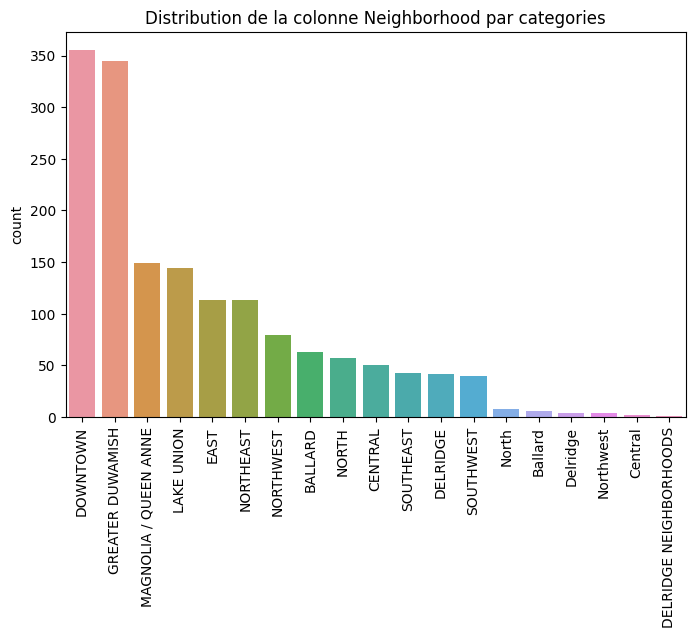

In [26]:
# Distribution de la colonne Neighborhood
nbhd_col = 'Neighborhood'

plt.figure(figsize=(8,5))
countplot = sns.countplot(x=nbhd_col, data=build_df, order=build_df[nbhd_col].sort_values().value_counts().index)
plt.xticks(rotation = 90)
plt.title("Distribution de la colonne " + nbhd_col + " par categories")
plt.xlabel("")
plt.show()

##### Il y a des doublons sur les catégories : 2 catégories BALLARD, 2 catégories NORTH, 2 catégories CENTRAL et 3 catégories DELRIDGE (avec DELRIDGE NEIGHBORHOODS qui est la même zone)

##### Pour y remédier, je réécris toutes les catégories avec des majuscules et je remplace DELRIDGE NEIGHBORHOODS par DELRIDGE

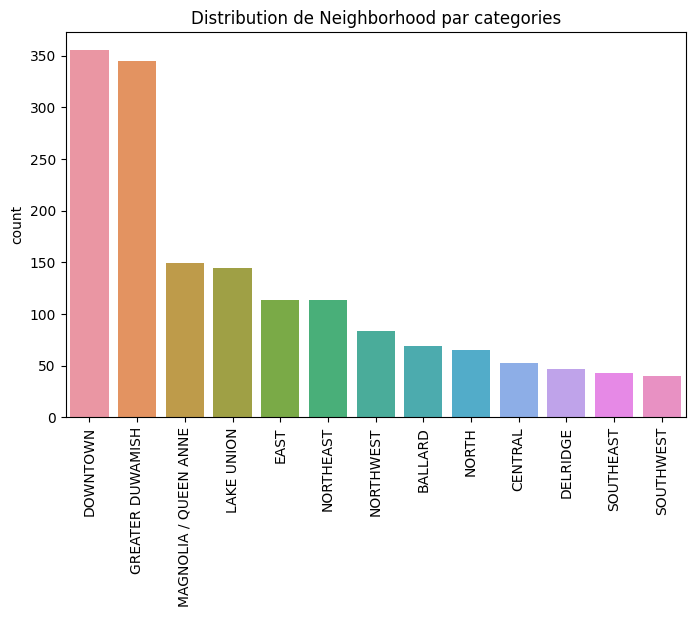

In [27]:
# Passage en lettre capital
build_df[nbhd_col] = build_df[nbhd_col].str.upper()

# Renomme la categorie DELRIDGE NEIGHBOORHOODS : DELRIDGE
build_df[nbhd_col] = build_df[nbhd_col].replace({'DELRIDGE NEIGHBORHOODS':'DELRIDGE'})

plt.figure(figsize=(8,5))
countplot = sns.countplot(x=nbhd_col, data=build_df, order=build_df[nbhd_col].sort_values().value_counts().index)
plt.xticks(rotation = 90)
plt.title("Distribution de " + nbhd_col + " par categories")
plt.xlabel("")
plt.show()

## Longitude et latitude

In [28]:
building_position_col = ['Longitude', 'Latitude']

display(build_df[building_position_col].describe())

,Longitude,Latitude
count,1618.000000,1618.000000
mean,-122.333331,47.615485
std,0.024572,0.048194
min,-122.411820,47.499170
25%,-122.343482,47.584560
50%,-122.333170,47.612185
75%,-122.322117,47.648962
max,-122.258640,47.733870


##### La longitude de Seattle est ~ [-122.2, -122.5] et la latitude est ~ [47.4, 47.8]. Les données de longitude et de latitude semblent correctes

## Affichage de la position de Seattle grace a Folium

In [29]:
import folium

In [30]:
# Ajouter un point sur une map pour chq building

def add_circle_to_map(row, background_map):
  x = row['Latitude']
  y = row['Longitude']
  folium.Circle([x, y], radius=50).add_to(background_map)

In [31]:
# Longitude et latitude de Seattle
seattle_location = [47.6062, -122.3321]

# Creer une map de Seattle
seattle_map = folium.Map(seattle_location, zoom_start=11)

# Ajouter un point pour chq building
build_df.apply(add_circle_to_map, background_map=seattle_map, axis=1)

seattle_map

## Building construction date

In [32]:
# les dates de constructions sont donnees par la variable YearBuilt
print(build_df['YearBuilt'].unique())
print(build_df['YearBuilt'].dtype)

[1927 1996 1969 1926 1980 1999 1904 1998 1928 1922 2004 1930 1983 1907
 1916 1985 1961 2001 1991 1955 1978 1949 1989 1906 1994 1992 1990 1950
 1900 1954 1911 1973 1920 1910 1982 1908 1959 2000 1997 1962 2008 1948
 1965 1929 2010 1938 1986 1970 2002 1923 2003 1957 1964 1941 1963 2006
 1915 1958 2011 1971 2007 1951 1953 1952 1960 1937 1966 1968 1925 1924
 2005 1931 1972 1914 1995 1981 1976 2009 1909 1988 1979 1947 1984 1956
 1912 1977 1921 1913 1945 1974 1975 1946 1967 1987 1940 1932 1993 1918
 1905 1902 1939 1944 1917 1942 1903 2012 2013 1919 1901 1936 1935 2014
 2015]
int64


##### Pour plus de facilite, je vais changer la variable YearBuilt par une variable Age qui me donnera le nombre d'annees de construction jusqu'a 2016

In [33]:
current_year = 2016

build_df['Age'] = current_year - build_df['YearBuilt']

build_df['Age'] = build_df['Age'].astype('int32')

print(build_df['Age'].unique())

[ 89  20  47  90  36  17 112  18  88  94  12  86  33 109 100  31  55  15
  25  61  38  67  27 110  22  24  26  66 116  62 105  43  96 106  34 108
  57  16  19  54   8  68  51  87   6  78  30  46  14  93  13  59  52  75
  53  10 101  58   5  45   9  65  63  64  56  79  50  48  91  92  11  85
  44 102  21  35  40   7 107  28  37  69  32  60 104  39  95 103  71  42
  41  70  49  29  76  84  23  98 111 114  77  72  99  74 113   4   3  97
 115  80  81   2   1]


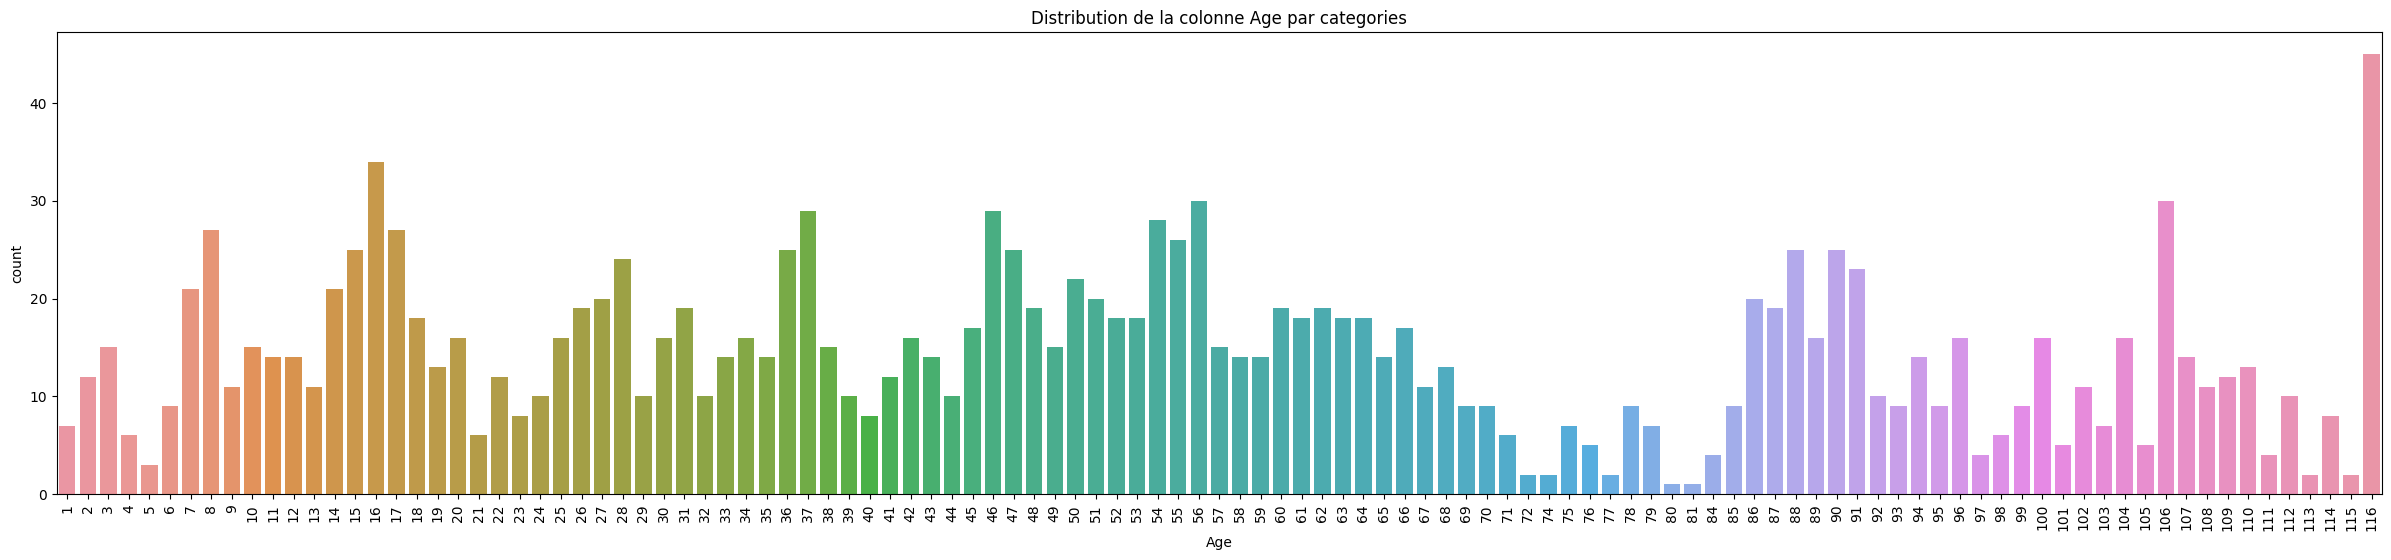

In [34]:
# Distribution
plt.figure(figsize=(30,6))
plt.title("Distribution de la colonne Age par categories")
sns.countplot(x='Age', data=build_df)
plt.xticks(rotation=90)
plt.show()

In [35]:
# Retrait de la colonne YearBuilt
col_to_remove.append('YearBuilt')

## Building elements

##### The elements of each property is given by its number of buildings (variable NumberofBuildings) and its number of floors (NumberofFloors)

,NumberofBuildings,NumberofFloors
count,1616.000000,1618.000000
mean,1.172649,4.124227
std,2.974487,6.617570
min,0.000000,0.000000
25%,1.000000,1.000000
50%,1.000000,2.000000
75%,1.000000,4.000000
max,111.000000,99.000000


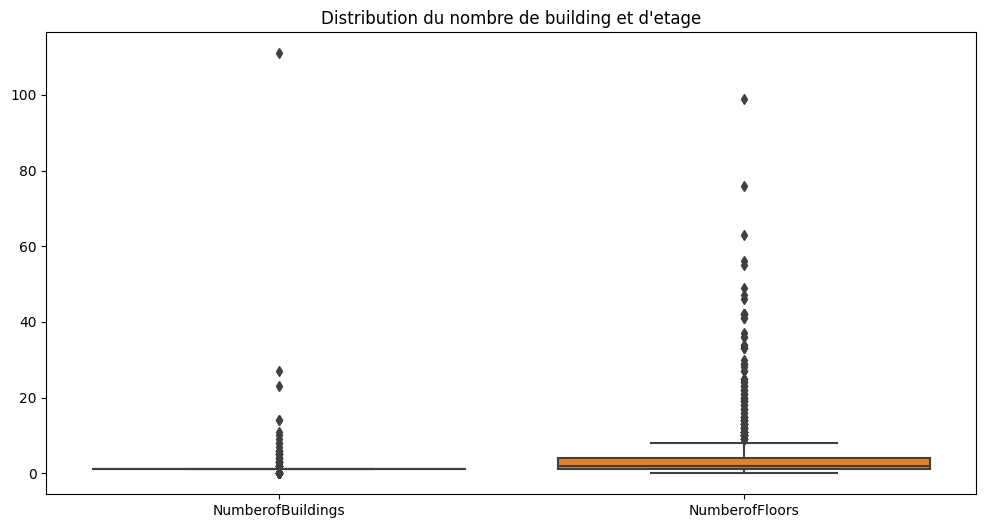

In [36]:
# Stock les elements des building
building_elem_col = ['NumberofBuildings', 'NumberofFloors']

display(build_df[building_elem_col].describe())

plt.figure(figsize=(12,6))
plt.title("Distribution du nombre de building et d'etage")
sns.boxplot(data=build_df[building_elem_col])
plt.show()

##### Je constate que certaines entrées ont NumberofBuildings=0 et NumberofFloors=0, ce qui est impossible pour un vrai bâtiment
##### Je vérifie d'abord les propriétés dont le nombre de bâtiments est égal à zéro

In [37]:
# buildings avec NumberofBuildings = 0
display(build_df[build_df['NumberofBuildings'] == 0][['PropertyName', 'Address', 'NumberofBuildings', 'NumberofFloors', 'YearBuilt', 'Age']])

,PropertyName,Address,NumberofBuildings,NumberofFloors,YearBuilt,Age
63,Polyclinic North && South,1200 Harvard Ave,0.0,3,1965,51
76,KCTS9,401 Mercer St,0.0,2,1986,30
160,Harbor Island: Warehouse E - DNRP-SWD,3235 16TH AVE SW,0.0,4,1916,100
201,Cox Media Group Seattle KIRO TV (322),2801 3rd Ave,0.0,3,1968,48
241,University District Office Buiding,1107 NE 45th St,0.0,5,1961,55
264,Thaw Building,8300 Military Rd South,0.0,1,1970,46
278,Fourth and Pike Building,1424 4th Ave,0.0,10,1926,90
280,Motif Seattle,1414 4th Ave,0.0,19,1973,43
291,Meridian (East),1501 7th Ave,0.0,4,1996,20
358,Westbridge,4209 W Marginal Way SW,0.0,1,1955,61


##### En regardant les adresses sur Google maps on voit bien que les batiments sont toujours presents. Je remplace donc NumeroofBuilding par 1

In [38]:
# Remplace 0 par 1
build_df['NumberofBuildings'] = build_df['NumberofBuildings'].replace(0, 1)

##### Puis je verifie les building avec un nombre d'etage = 0

In [39]:
display(build_df[build_df['NumberofFloors'] == 0][['PropertyName', 'Address', 'NumberofBuildings', 'NumberofFloors', 'YearBuilt', 'Age']])

,PropertyName,Address,NumberofBuildings,NumberofFloors,YearBuilt,Age
166,Grand Hyatt Seattle,721 Pine St,1.0,0,1999,17
487,Arnold Pavilion,1221 Madison Street,1.0,0,2004,12
488,2200 Westlake - SEDO,2200 Westlake Ave.,1.0,0,2006,10
564,Pacific Place,600 Pine Street,1.0,0,1999,17
1754,HART First Hill LLC,1124 Columbia Street,1.0,0,1945,71
1993,(ID#24086)Campus1:KC Metro Transit Atlantic Ce...,1333 AIRPORT WAY S,10.0,0,1991,25
3130,Sandpoint #5,7561 63rd Ave NE,1.0,0,1940,76
3131,Sandpoint #25,6222 NE 74th St,1.0,0,1960,56
3132,Sandpoint #29,6200 NE 74th ST,1.0,0,1960,56
3168,Magnuson,7400 Sand Point Way NE,8.0,0,1929,87


##### En regargant sur Google j'ai trouve les infos suivantes :

##### Grand Hyatt Seattle : 4-star hotel with 30 floors
##### Arnold Pavilion : 12 floors building, part of the Swedish Medical Center
##### 2200 Westlake : 3 floors building
##### Pacific Place : 3 floors building
##### HART First Hill LLC : 7 floors building, part of the Swedish Medial Center
##### KC Metro Transit Atlantic : 1 floor warehouse
##### Sandpoint #5 : 2 floors building
##### Sandpoint #25 : 2 floors building
##### Sandpoint #29 : 3 floors building
##### Magnuson : 2 floors building
##### Smilow Rainier Vista Boys & Girls Club : 2 floors building
##### University of Washington : lots of buildings, 4 floors in average

##### Correction du nombre d'etage dans le dataframe

In [40]:
# Grand Hyatt Seattle
build_df.loc[[166]]['NumberofFloors'] = 30

# Arnold Pavilion
build_df.loc[[487]]['NumberofFloors'] = 12

# 2200 Westlake, Pacific Place, Sandpoint #29
build_df.loc[[488, 564, 3132]]['NumberofFloors'] = 3

# HART First Hill LLC
build_df.loc[[1754]]['NumberofFloors'] = 7

# KC Metro Transit Atlantic
build_df.loc[[1993]]['NumberofFloors'] = 1

# Sandpoint #5, Sandpoint #25, Magnuson, Smilow Rainier Vista Boys & Girls Club
build_df.loc[[3130, 3131, 3168, 3273]]['NumberofFloors'] = 2

# University of Washington
build_df.loc[[3274]]['NumberofFloors'] = 4

##### Dans la distribution, nous pouvons voir que la variable NumberofBuildings contient une valeur aberrante 111 qui semble trop importante pour une seule propriété.
##### De même, la variable NumberofFloors contient plusieurs valeurs aberrantes avec plus de 70 étages.

In [41]:
display(build_df[build_df['NumberofBuildings'] == 111])

display(build_df[build_df['NumberofFloors'] > 70])

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,NewBuildingType,Age
3274,49967,2016,Campus,University,University of Washington - Seattle Campus,NE 45th St & Brooklyn Ave,Seattle,WA,98105.0,1625049001,...,0.0,0.0,False,NaN,Compliant,NaN,11140.56,1.2,Education,116


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,NewBuildingType,Age
559,775,2016,NonResidential,Large Office,Columbia Center - 2015,701 5th Avenue,Seattle,WA,98104.0,0942000640,...,50857.63281,5085763.0,False,NaN,Compliant,NaN,882.56,0.45,Office,31
1359,21611,2016,NonResidential,Worship Facility,Seattle Chinese Baptist Church,5801 Beacon Avenue South,Seattle,WA,98108.0,2124049098,...,0.00000,0.0,False,NaN,Compliant,NaN,2.27,0.10,Religion,39


##### Visiblement la valeur aberrante de NumberofBuilding est l'Université de Washington et que le nombre de bâtiments est correct.
##### Les deux valeurs aberrantes pour NumberofFloors sont le Columbia Center et la Seattle Chinese Baptist Church. le Columbia Center compte 76 étages, ce qui est correct.
##### En revanche, l'église ne peut pas avoir 99 étages. Je fixe le nombre d'étages de l'église à 1

In [42]:
build_df.loc[[1359], 'NumberofFloors'] = 1

In [43]:
build_df[building_elem_col].dtypes

NumberofBuildings    float64
NumberofFloors         int64
dtype: object

##### Jetransforme les deux variables Nombre de bâtiments et Nombre d'étages en nombres entiers

In [44]:
build_df[building_elem_col] = build_df[building_elem_col].astype('Int32')

## Building Area

##### La surface des bâtiments est donnée par la surface brute de plancher. Les variables associées sont PropertyGFATotal, PropertyGFAParking et PropertyGFABuilding(s)

,count,mean,std,min,25%,50%,75%,max
PropertyGFATotal,1618.0,119838.795426,300796.762829,11285.0,29500.50,49250.5,106030.75,9320156.0
PropertyGFABuilding(s),1618.0,106618.759580,287413.419192,10925.0,28507.75,47316.5,94853.25,9320156.0
PropertyGFAParking,1618.0,13220.035847,42922.136316,0.0,0.00,0.0,0.00,512608.0
LargestPropertyUseTypeGFA,1612.0,99411.576923,280273.135985,5656.0,25575.50,43770.5,92036.75,9320156.0
SecondLargestPropertyUseTypeGFA,831.0,37303.040068,70249.480103,0.0,5350.00,12023.0,32128.00,686750.0
ThirdLargestPropertyUseTypeGFA,340.0,14942.709996,36868.508747,0.0,2624.25,5884.0,13107.25,459748.0


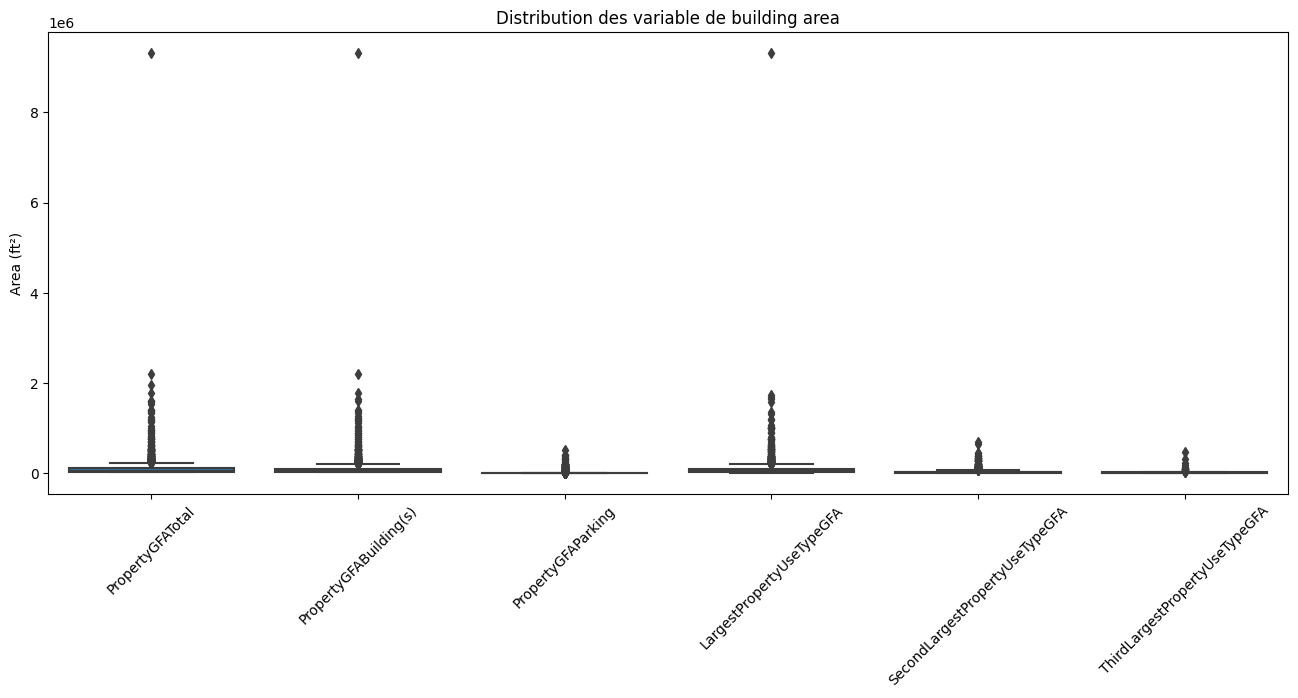

In [45]:
# Nouvelle variable pour les colonnes du building area
building_area_col = ['PropertyGFATotal', 'PropertyGFABuilding(s)', 'PropertyGFAParking', 'LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']

display(build_df[building_area_col].describe().T)

plt.figure(figsize=(16,6))
plt.title("Distribution des variable de building area")
sns.boxplot(data=build_df[building_area_col])
plt.xticks(rotation = 45)
plt.ylabel("Area (ft²)")
plt.show()

##### According to the data source, the variable PropertyGFATotal is the addition of the variables PropertyGFABuilding(s) and PropertyGFAParking.
##### Verification

In [46]:
if(build_df['PropertyGFATotal'].equals(build_df['PropertyGFABuilding(s)'] + build_df['PropertyGFAParking']) == True):
  print("PropertyGFATotal est la somme correcte de PropertyGFABuilding(s) et PropertyGFAParking")

PropertyGFATotal est la somme correcte de PropertyGFABuilding(s) et PropertyGFAParking


##### Étant donné que PropertyGFATotal est l'addition d'autres variables, je peux la supprimer

In [47]:
building_area_col.remove('PropertyGFATotal')
col_to_remove.append('PropertyGFATotal')

##### Nous pouvons voir sur la distribution précédente qu'il y a une grande valeur aberrante (environ 9 millions de pieds carrés)

In [48]:
gfa_max_value = build_df['PropertyGFABuilding(s)'].max()
gfa_max_index = build_df['PropertyGFABuilding(s)'].idxmax()
print("La plus grande surface de plancher est " + str(gfa_max_value) + " (index=" + str(gfa_max_index) + ")")

display(build_df.loc[build_df.index == gfa_max_index])

La plus grande surface de plancher est 9320156 (index=3274)


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,NewBuildingType,Age
3274,49967,2016,Campus,University,University of Washington - Seattle Campus,NE 45th St & Brooklyn Ave,Seattle,WA,98105.0,1625049001,...,0.0,0.0,False,NaN,Compliant,NaN,11140.56,1.2,Education,116


##### La propriété aberrante est l'Université de Washington. La valeur de sa GFA est cohérente car l'université est composée de 111 bâtiments

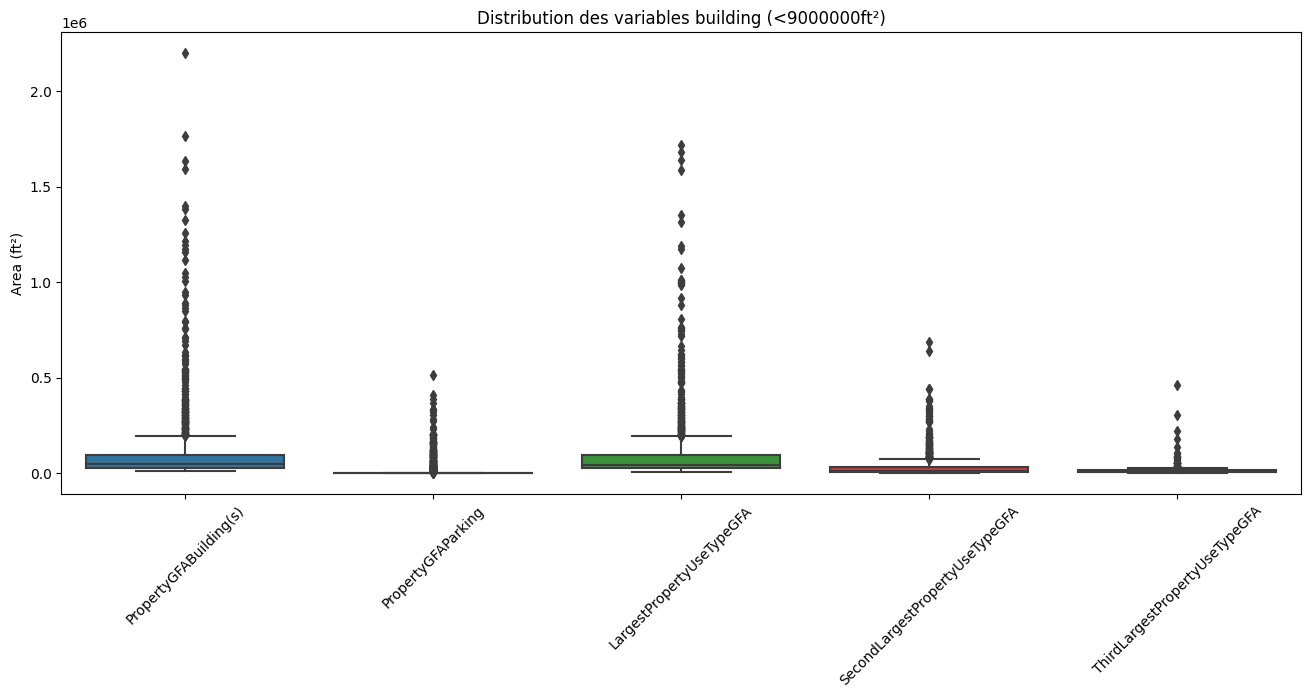

In [49]:
plt.figure(figsize=(16,6))
plt.title("Distribution des variables building (<9000000ft²)")
sns.boxplot(data=build_df[build_df['PropertyGFABuilding(s)'] < 9000000][building_area_col])
plt.ylabel("Area (ft²)")
plt.xticks(rotation = 45)
plt.show()

In [50]:
display(build_df[building_area_col].isna().sum())

PropertyGFABuilding(s)                0
PropertyGFAParking                    0
LargestPropertyUseTypeGFA             6
SecondLargestPropertyUseTypeGFA     787
ThirdLargestPropertyUseTypeGFA     1278
dtype: int64

##### De nombreuses valeurs sont manquantes (respectivement 6, 787 et 1278 valeurs). En outre, ces données sont difficiles à prédire et pourraient constituer une fuite de données pour la prédiction. J'ai donc décidé de les supprimer

In [51]:
col_to_remove.extend(['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA'])

##### Je souhaite à présent obtenir une meilleure vue de la distribution de l'AGF des bâtiments. Pour éliminer l'effet des valeurs aberrantes, j'essaie d'afficher le logarithme commun

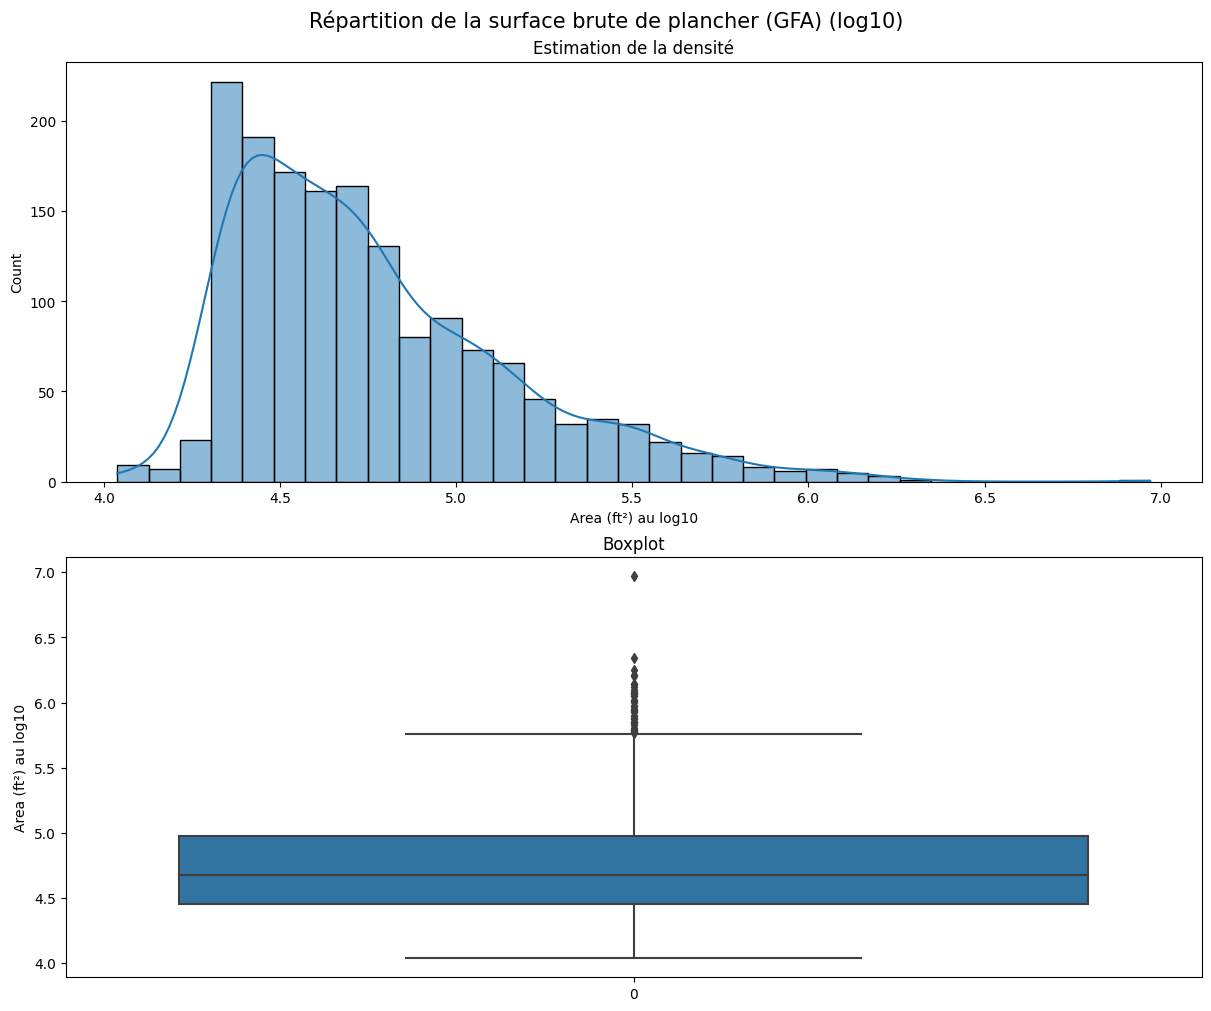

In [52]:
# Calcule le log10
building_gfa_log10 = np.log10(build_df['PropertyGFABuilding(s)'])

fig, ax = plt.subplots(2, 1, figsize=(12, 10), constrained_layout=True)
plt.suptitle("Répartition de la surface brute de plancher (GFA) (log10)", fontsize=15)

ax[0].set_title("Estimation de la densité")
ax[0].set_xlabel("Area (ft²) au log10")
sns.histplot(data=building_gfa_log10, kde=True, ax=ax[0])

# Draw boxplot
ax[1].set_title("Boxplot")
ax[1].set_ylabel("Area (ft²) au log10")
sns.boxplot(data=building_gfa_log10, ax=ax[1])
plt.show()

##### J'utilise le log10 de la variable PropertyGFABuilding(s). Le logarithme ne perd pas d'information et normalise la distribution

In [53]:
# Remplacer le(s) bâtiment(s) de propriété existant(s) par la transformation log10
build_df['PropertyGFABuildings(log10)'] = building_gfa_log10

build_df = build_df.drop(columns=['PropertyGFABuilding(s)'])

## Building energy use

##### Les consommations d'énergie des bâtiments sont identifiées par plusieurs variables. Elles comprennent la consommation de gaz, d'électricité et de vapeur

In [54]:
building_energy_col = ['SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)']

display(build_df[building_energy_col].describe().T)

,count,mean,std,min,25%,50%,75%,max
SiteEUI(kBtu/sf),1615.0,7.192842e+01,7.462045e+01,0.00000,3.355000e+01,5.140000e+01,8.030000e+01,8.344000e+02
SiteEUIWN(kBtu/sf),1615.0,7.429542e+01,7.556308e+01,0.00000,3.525000e+01,5.350000e+01,8.365000e+01,8.344000e+02
SourceEUI(kBtu/sf),1616.0,1.759941e+02,1.880872e+02,0.00000,7.605000e+01,1.306500e+02,2.022750e+02,2.620000e+03
SourceEUIWN(kBtu/sf),1616.0,1.781517e+02,1.880286e+02,-2.10000,7.867500e+01,1.333500e+02,2.038500e+02,2.620000e+03
SiteEnergyUse(kBtu),1616.0,8.519647e+06,3.069470e+07,0.00000,1.213240e+06,2.502106e+06,6.882718e+06,8.739237e+08
SiteEnergyUseWN(kBtu),1615.0,8.125652e+06,2.235698e+07,0.00000,1.270683e+06,2.654316e+06,7.069440e+06,4.716139e+08
SteamUse(kBtu),1616.0,5.375023e+05,5.617638e+06,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,1.349435e+08
Electricity(kWh),1616.0,1.737068e+06,6.184826e+06,-33826.80078,2.103551e+05,4.672902e+05,1.434812e+06,1.925775e+08
Electricity(kBtu),1616.0,5.926877e+06,2.110263e+07,-115417.00000,7.177312e+05,1.594394e+06,4.895578e+06,6.570744e+08
NaturalGas(therms),1616.0,1.940810e+04,9.471774e+04,0.00000,0.000000e+00,4.752735e+03,1.464761e+04,2.979090e+06


##### J'utilise une matrice de corrélation pour détecter tout lien entre les variables énergétiques

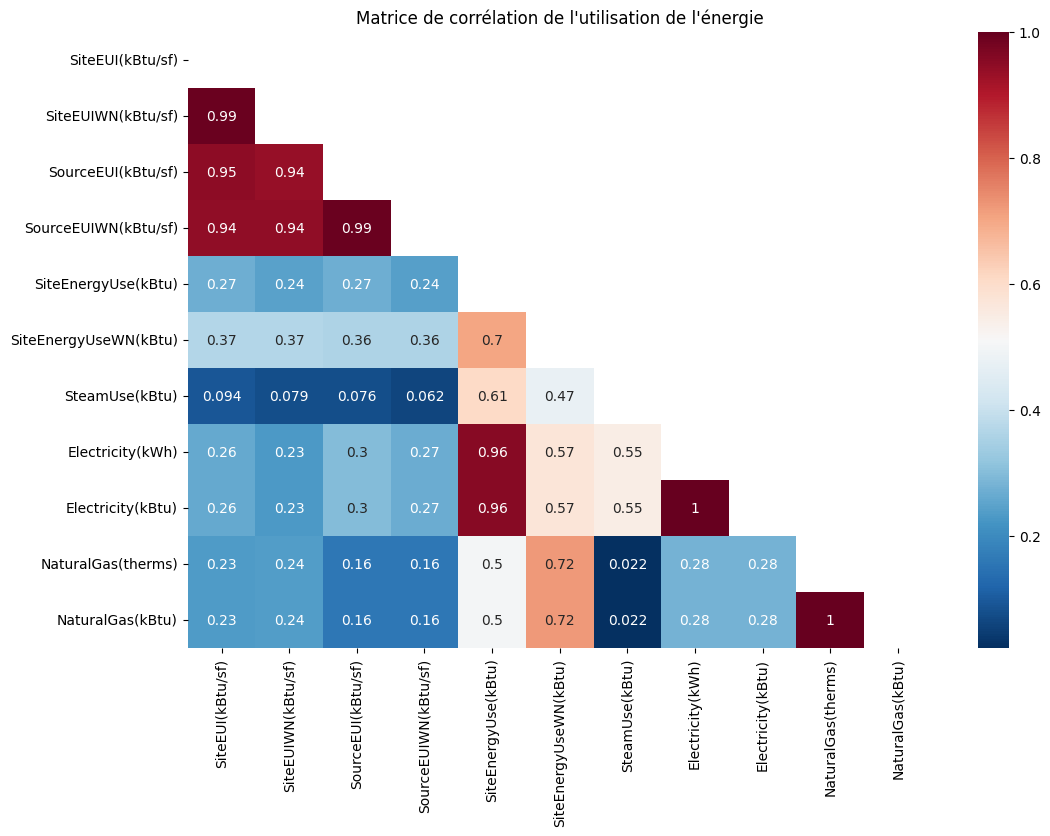

In [55]:
corr = build_df[building_energy_col].corr()

plt.figure(figsize=(12,8))
plt.title("Matrice de corrélation de l'utilisation de l'énergie")
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr.abs(), mask=mask, cmap='RdBu_r', annot=True)
plt.show()

##### La matrice donne les informations suivantes :

##### L'électricité(kBtu) est parfaitement corrélée à l'électricité(kWh)
##### Gaz naturel(kBtu) est parfaitement corrélé à Gaz naturel(therms)
##### SiteEUI est fortement corrélé à SiteEUIWN, SourceEUI et SourceEUIWN
##### SourceEUI est fortement corrélé à SourceEUIWN, SiteEUI et SiteEUIWN
##### SiteEnergyUse est fortement corrélé à Electricity
##### Pour cette étude, j'ai besoin de prédire la consommation totale d'énergie des bâtiments.

##### Je choisis donc la variable SiteEnergyUse(kBtu) comme premier objectif. Il s'agit de la quantité annuelle d'énergie consommée par le bien immobilier, toutes sources d'énergie confondues. Lorsque l'on compare des bâtiments, il est normalement préférable d'utiliser des données normalisées en fonction des conditions météorologiques, mais ici, j'ai supposé que les conditions météorologiques étaient les mêmes dans tous les bâtiments de Seattle et qu'elles n'avaient aucune influence.

##### Ensuite, pour éviter les fuites de données, j'ai supprimé les autres variables énergétiques

In [56]:
col_to_remove.extend(['SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)'])

##### Vérifions la distribution de l'objectif SiteEnergyUse(kBtu)

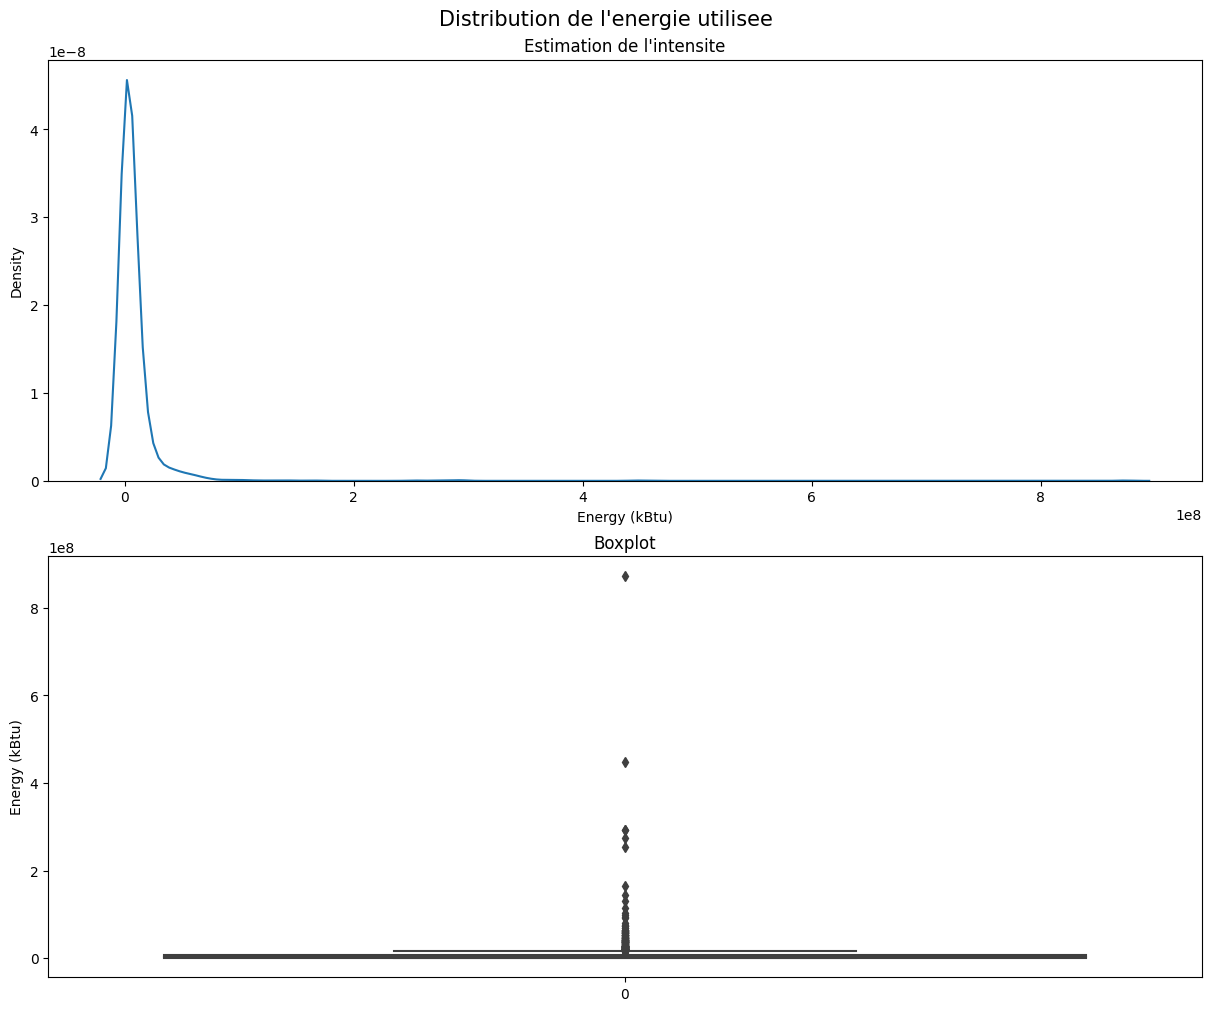

In [57]:
energy_use_col = 'SiteEnergyUse(kBtu)'

fig, ax = plt.subplots(2, 1, figsize=(12, 10), constrained_layout=True)
plt.suptitle("Distribution de l'energie utilisee", fontsize=15)

# Draw distribution
ax[0].set_title("Estimation de l'intensite")
ax[0].set_xlabel("Energy (kBtu)")
sns.kdeplot(data=build_df[energy_use_col], ax=ax[0])

# Draw boxplot
ax[1].set_title("Boxplot")
ax[1].set_ylabel("Energy (kBtu)")
sns.boxplot(data=build_df[energy_use_col], ax=ax[1])
plt.show()

##### Il y a une valeur aberrante importante pour SiteEnergyUse à environ 880 MkBtu.
##### Je souhaite tout d'abord déterminer quel bâtiment est responsable de cette valeur aberrante.

In [58]:
energy_max_value = build_df[energy_use_col].max()
energy_max_index = build_df[energy_use_col].idxmax()
print("La consommation d'énergie la plus importante est " + str(energy_max_value) + " (index=" + str(energy_max_index) + ")")

La consommation d'énergie la plus importante est 873923712.0 (index=3274)


In [59]:
display(build_df.loc[[energy_max_index]])

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,NewBuildingType,Age,PropertyGFABuildings(log10)
3274,49967,2016,Campus,University,University of Washington - Seattle Campus,NE 45th St & Brooklyn Ave,Seattle,WA,98105.0,1625049001,...,0.0,False,NaN,Compliant,NaN,11140.56,1.2,Education,116,6.969423


##### Sans surprise, l'aberration est à nouveau l'Université de Washington. Ce qui semble cohérent car elle est composée d'une centaine de bâtiments
##### J'ai également noté qu'il y a des valeurs nulles pour la cible SiteEnergyUse(kBtu). Vérifions les propriétés qui ne consomment pas d'énergie

In [60]:
display(build_df[build_df[energy_use_col] == 0])

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,NewBuildingType,Age,PropertyGFABuildings(log10)
28,34,2016,SPS-District K-12,K-12 School,Meany Building,301/300 21st Ave. E.,Seattle,WA,98112.0,0688000090,...,0.0,False,NaN,Missing Data,NaN,0.00,0.00,Education,61,5.101579
31,37,2016,SPS-District K-12,K-12 School,John Hay Elementary,201 Garfield St.,Seattle,WA,98109.0,0809000005,...,0.0,False,NaN,Missing Data,NaN,10.43,0.20,Education,27,4.712498
62,87,2016,SPS-District K-12,K-12 School,Arbor Heights Elementary,3701 S.W. 104th St.,Seattle,WA,98146.0,2518400005,...,0.0,False,NaN,Missing Data,NaN,4.19,0.08,Education,68,4.727151
81,118,2016,SPS-District K-12,K-12 School,Pathfinder K-8,1901 SW Genesee St.,Seattle,WA,98106.0,1324039116,...,0.0,False,NaN,Missing Data,NaN,11.84,0.16,Education,17,4.871970
85,122,2016,SPS-District K-12,K-12 School,John Muir Elementary,3301 S. Horton St.,Seattle,WA,98144.0,1524049002,...,0.0,False,NaN,Missing Data,NaN,16.36,0.28,Education,25,4.770359
95,140,2016,SPS-District K-12,K-12 School,B.F. Day Elementary,3921 Linden Ave. N.,Seattle,WA,98103.0,1931301145,...,0.0,False,NaN,Missing Data,NaN,14.67,0.22,Education,25,4.823396
133,217,2016,SPS-District K-12,K-12 School,Whitman Middle,9201 15th Ave. NW.,Seattle,WA,98117.0,3526039131,...,4318917.0,False,NaN,Missing Data,NaN,229.38,1.43,Education,57,5.204852
139,227,2016,SPS-District K-12,K-12 School,Washington Middle,2101 S. Jackson,Seattle,WA,98144.0,3646100540,...,3217877.0,False,NaN,Missing Data,NaN,170.90,1.25,Education,53,5.134139
152,242,2016,SPS-District K-12,K-12 School,Olympic View Elementary,504 N.E. 95th St.,Seattle,WA,98115.0,5100404840,...,0.0,False,NaN,Missing Data,NaN,0.00,0.00,Education,27,4.722568
304,435,2016,NonResidential,Other,Washington State Convention Center,705 Pike St,Seattle,WA,98101.0,1978200105,...,0.0,False,NaN,Non-Compliant,NaN,0.00,0.00,Culture,26,6.146128


##### Comme je ne trouve pas la raison pour laquelle ces bâtiments ne consomment pas d'énergie, je décide de les supprimer.

In [61]:
index = build_df[build_df[energy_use_col] == 0].index

build_df = build_df.drop(index)
print("Supprimer les " + str(len(index)) + " biens dont la consommation d'énergie est nulle")

Supprimer les 17 biens dont la consommation d'énergie est nulle


##### Je souhaite à présent obtenir une meilleure vue de la distribution de la consommation d'énergie cible. Pour éliminer l'effet des valeurs aberrantes, j'essaie d'afficher le logarithme commun

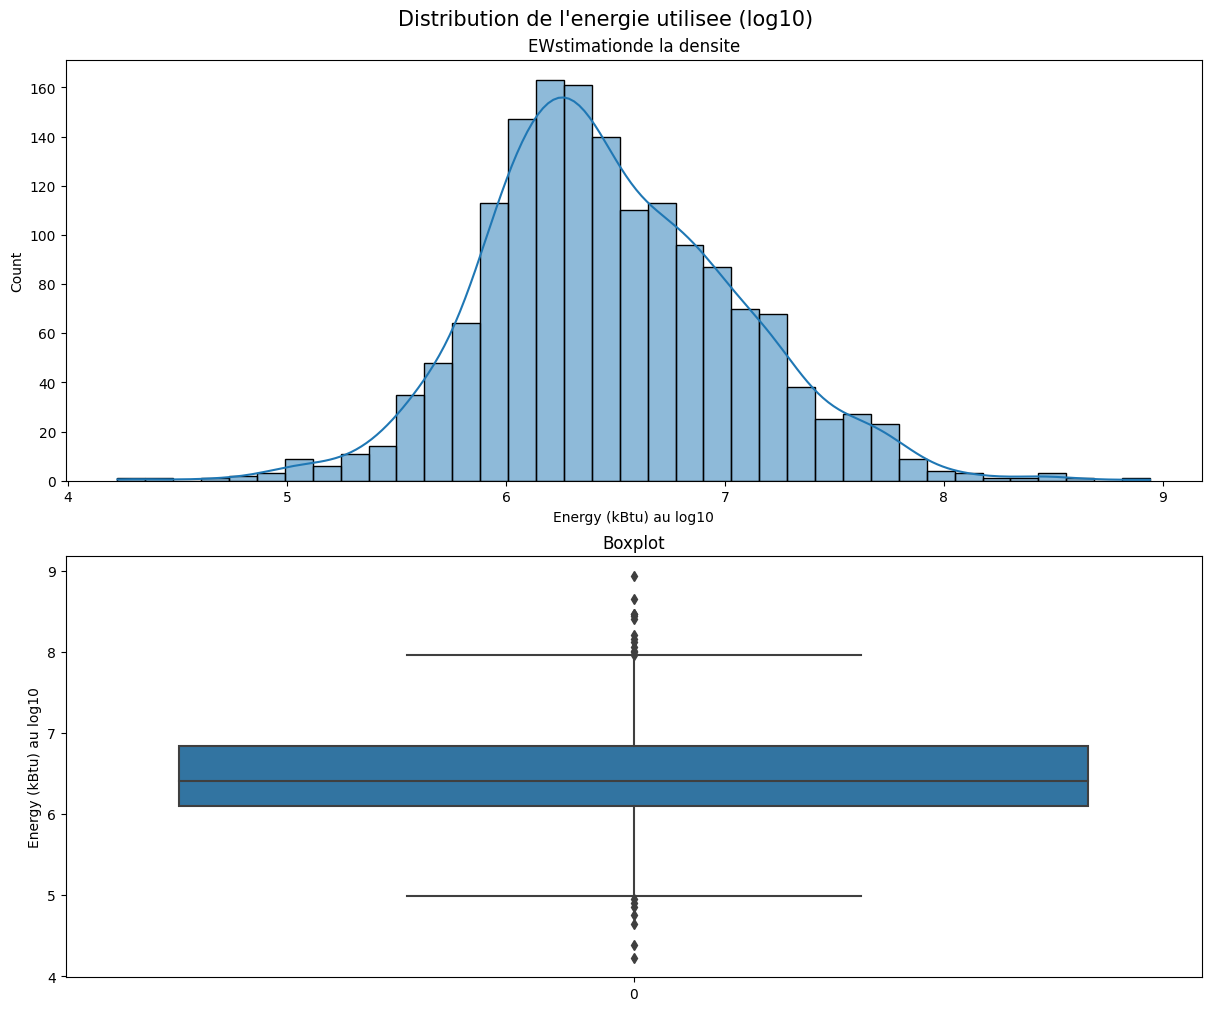

In [62]:
energy_use_log10 = np.log10(build_df[energy_use_col])

# Init figure
fig, ax = plt.subplots(2, 1, figsize=(12, 10), constrained_layout=True)
plt.suptitle("Distribution de l'energie utilisee (log10)", fontsize=15)

# Draw distribution
ax[0].set_title("EWstimationde la densite")
ax[0].set_xlabel("Energy (kBtu) au log10")
sns.histplot(data=energy_use_log10, kde=True, ax=ax[0])

# Draw boxplot
ax[1].set_title("Boxplot")
ax[1].set_ylabel("Energy (kBtu) au log10")
sns.boxplot(data=energy_use_log10, ax=ax[1])
plt.show()

##### Je décide d'utiliser le log10 de cette cible pour la prédiction, je le remplace dans le dataframe

In [63]:
build_df['SiteEnergyUse(log10)'] = energy_use_log10

build_df = build_df.drop(columns=[energy_use_col])

##### Étant donné que SiteEnergyUse(kBtu) est une cible pour la prédiction, je supprime également les entrées avec une valeur NaN pour cette variable

In [64]:
energy_use_col = 'SiteEnergyUse(log10)'

print("Il y a " + str(build_df[energy_use_col].isna().sum()) + " NaN valeurs pour la colonne " + energy_use_col)

build_df = build_df.dropna(subset=[energy_use_col])

Il y a 2 NaN valeurs pour la colonne SiteEnergyUse(log10)


## Building GHGE

##### Deux variables fournissent des informations sur les émissions de gaz à effet de serre (GES)

In [65]:
building_ghge_col = ['TotalGHGEmissions', 'GHGEmissionsIntensity']
building_ghge_unit = ['metric ton of co2 equivalent', 'kg of co2 equivalent per sf²']

display(build_df[building_ghge_col].describe())

,TotalGHGEmissions,GHGEmissionsIntensity
count,1599.000000,1599.000000
mean,187.361639,1.599106
std,767.716666,2.345687
min,-0.800000,-0.020000
25%,20.005000,0.350000
50%,49.180000,0.860000
75%,139.285000,1.825000
max,16870.980000,34.090000


##### Pour notre étude, je dois prédire les émissions totales de gaz à effet de serre des bâtiments.
##### La variable TotalGHGEmissions est la deuxième cible. Il s'agit de la quantité totale d'émissions de gaz à effet de serre, y compris le dioxyde de carbone, le méthane et l'oxyde nitreux, rejetée dans l'atmosphère en raison de la consommation d'énergie du bien immobilier, mesurée en tonnes d'équivalent dioxyde de carbone.

##### L'intensité des émissions de gaz à effet de serre correspond au total des émissions de gaz à effet de serre divisé par la superficie totale du bien. Je décide de le supprimer.

In [66]:
col_to_remove.append('GHGEmissionsIntensity')

##### Vérifions maintenant la distribution de l'objectif TotalGHGEmission

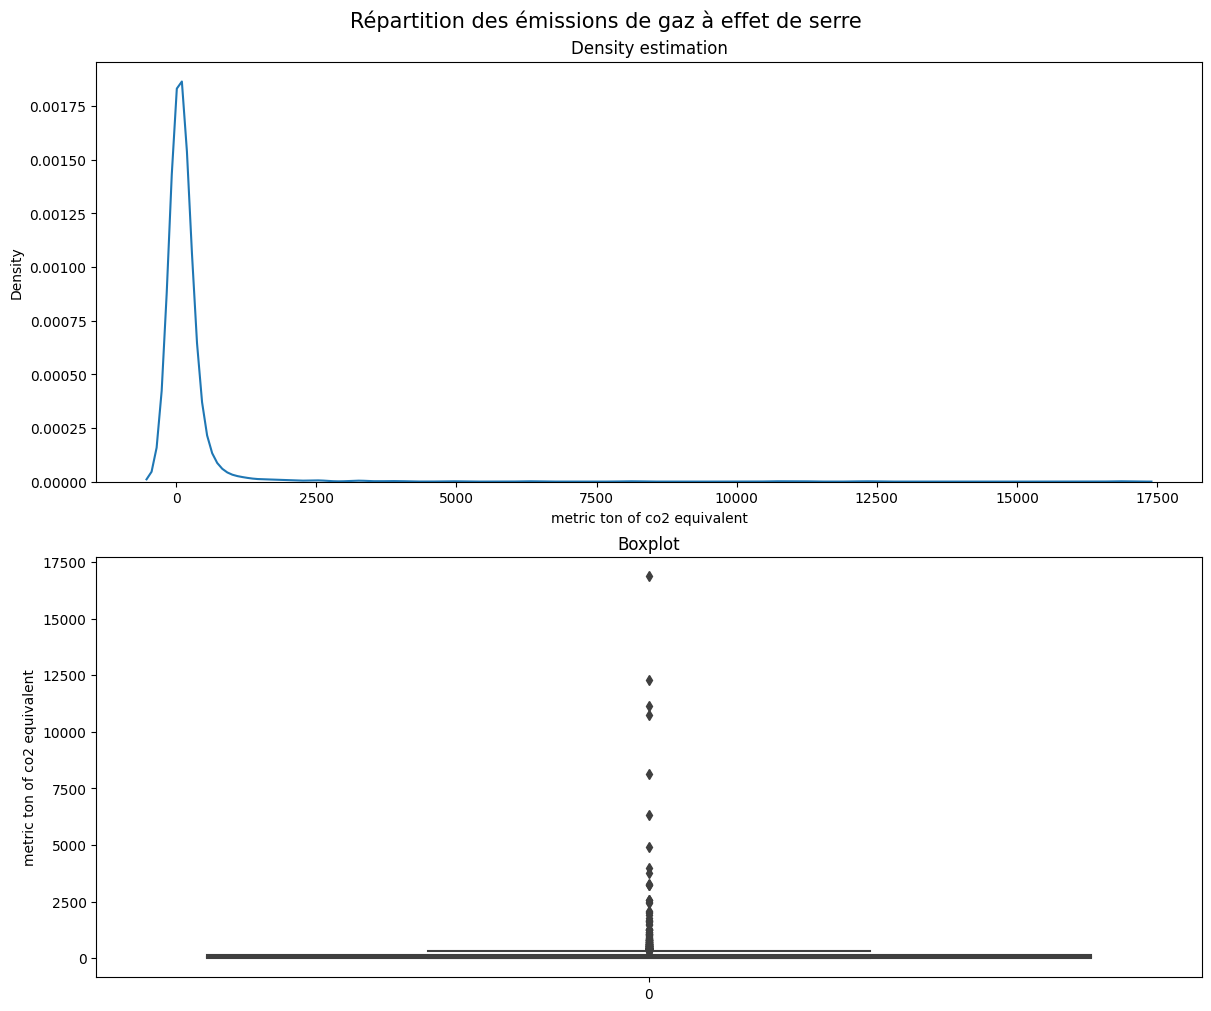

In [67]:
ghge_col = 'TotalGHGEmissions'

fig, ax = plt.subplots(2, 1, figsize=(12, 10), constrained_layout=True)
plt.suptitle("Répartition des émissions de gaz à effet de serre", fontsize=15)

ax[0].set_title("Density estimation")
ax[0].set_xlabel("metric ton of co2 equivalent")
sns.kdeplot(data=build_df[ghge_col], ax=ax[0])

ax[1].set_title("Boxplot")
ax[1].set_ylabel("metric ton of co2 equivalent")
sns.boxplot(data=build_df[ghge_col], ax=ax[1])
plt.show()

##### Il y a quatre valeurs aberrantes importantes pour l'émission totale de GES avec plus de 10000 tonnes d'équivalent CO2. Je souhaite tout d'abord déterminer quel bâtiment est responsable de ces valeurs aberrantes

In [68]:
# Affichager ghge > 10000
display(build_df[build_df[ghge_col] > 10000])

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,NewBuildingType,Age,PropertyGFABuildings(log10),SiteEnergyUse(log10)
35,43,2016,Campus,Mixed Use Property,Plant 2 Site,7755 E MARGINAL WAY S,Seattle,WA,98108.0,0022000005,...,False,NaN,Compliant,NaN,16870.98,34.09,Office,24,5.694460,8.651651
170,276,2016,NonResidential,Hospital,Harborview Medical Center,325 9th Ave.,Seattle,WA,98104.0,8590900220,...,False,NaN,Compliant,NaN,10734.57,9.26,Healthcare,16,6.063968,8.467002
618,828,2016,NonResidential,Hospital,Swedish First Hill,747 Broadway,Seattle,WA,98122.0,1978201096,...,False,NaN,Compliant,NaN,12307.16,6.97,Healthcare,22,6.246983,8.464809
3274,49967,2016,Campus,University,University of Washington - Seattle Campus,NE 45th St & Brooklyn Ave,Seattle,WA,98105.0,1625049001,...,False,NaN,Compliant,NaN,11140.56,1.20,Education,116,6.969423,8.941474


##### Deux des valeurs aberrantes sont des hôpitaux, ce qui semble correct puisque ces établissements émettent beaucoup de gaz à effet de serre.

##### L'une des valeurs aberrantes est (à nouveau) l'université de Washington. Étant donné le nombre de bâtiments que possède cette propriété, il semble cohérent qu'elle émette également beaucoup de gaz à effet de serre.

##### La dernière valeur aberrante semble être un bâtiment de Beoing. C'est aussi le maximum de la variable GHGEmissionIntensity. Comme je ne peux pas expliquer pourquoi ses émissions sont beaucoup plus importantes que celles des autres bâtiments du même type, je décide de le supprimer.

In [69]:
build_df = build_df.drop(35)

##### Il existe des valeurs égales à zéro et inférieures pour TotalGHGEmissions. Je souhaite trouver toutes les valeurs nulles et les propriétés associées, car il est étrange qu'un bâtiment n'émette aucun gaz à effet de serre

In [70]:
display(build_df[build_df[ghge_col] <= 0])

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,NewBuildingType,Age,PropertyGFABuildings(log10),SiteEnergyUse(log10)
513,700,2016,NonResidential,Supermarket / Grocery Store,IUC- Whole Foods Interbay,2001 15th Avenue West,Seattle,WA,98119.0,7666201460,...,False,NaN,Compliant,NaN,0.0,0.00,Stores,8,4.757214,7.097784
3206,49784,2016,NonResidential,Small- and Mid-Sized Office,Bullitt Center,1501 E. Madison St.,Seattle,WA,98122.0,7234600195,...,False,NaN,Compliant,NaN,-0.8,-0.02,Office,3,4.716003,5.534947


##### Le bâtiment dont les émissions de gaz à effet de serre sont négatives est le Bullitt Center. J'ai cherché des informations sur ce bâtiment et j'ai découvert qu'il possède de grands panneaux de sonar qui produisent plus d'électricité qu'ils n'en consomment (https://bullittcenter.org/building/building-features/solar-district-1/). Cela explique la valeur négative. Je décide néanmoins de l'éliminer car il peut interférer avec les résultats de la prédiction.

##### Le bâtiment dont les émissions de gaz à effet de serre sont nulles est une simple épicerie, je l'ai également supprimé.

In [71]:
index = build_df[build_df[ghge_col] <= 0].index

build_df = build_df.drop(index)

##### Je souhaite maintenant avoir une meilleure vue de la cible TotalGHGEmission. Pour éliminer l'effet des valeurs aberrantes, j'essaie d'afficher le logarithme commun

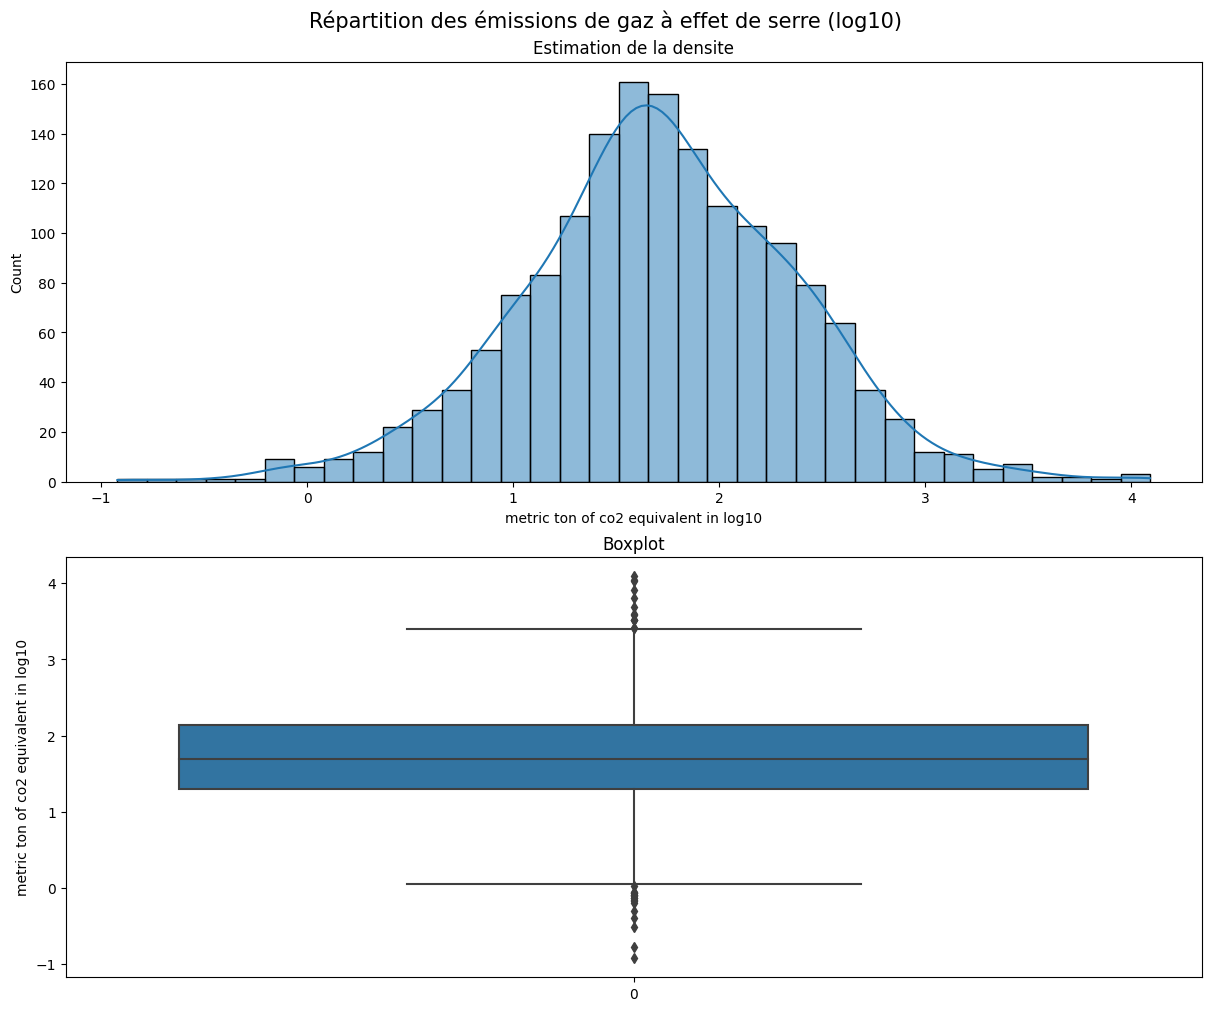

In [72]:
ghge_log10 = np.log10(build_df[ghge_col])

fig, ax = plt.subplots(2, 1, figsize=(12, 10), constrained_layout=True)
plt.suptitle("Répartition des émissions de gaz à effet de serre (log10)", fontsize=15)

ax[0].set_title("Estimation de la densite")
ax[0].set_xlabel("metric ton of co2 equivalent in log10")
sns.histplot(data=ghge_log10, kde=True, ax=ax[0])

ax[1].set_title("Boxplot")
ax[1].set_ylabel("metric ton of co2 equivalent in log10")
sns.boxplot(data=ghge_log10, ax=ax[1])
plt.show()

##### Je décide d'utiliser le log10 de cette cible pour la prédiction, je le remplace dans le dataframe

In [73]:
build_df['TotalGHGEmissions(log10)'] = ghge_log10

build_df = build_df.drop(columns=[ghge_col])

##### Étant donné que TotalGHGEmissions est une cible pour la prédiction, je supprime également les entrées avec une valeur NaN pour cette variable

In [74]:
ghge_col = 'TotalGHGEmissions(log10)'

print("Il y a " + str(build_df[ghge_col].isna().sum()) + " NaN valeurs pour la colonne " + ghge_col)

build_df = build_df.dropna(subset=[ghge_col])

Il y a 0 NaN valeurs pour la colonne TotalGHGEmissions(log10)


## Building ENERGY STAR score

##### La note ENERGY STAR donne un aperçu complet de la performance énergétique d'un bâtiment, en tenant compte de ses actifs physiques, de son fonctionnement et du comportement de ses occupants. Elle est exprimée sur une échelle de 1 à 100 facile à comprendre, où plus la note est élevée, meilleure est la performance énergétique du bâtiment. Il vous aidera à identifier les bâtiments de votre portefeuille à améliorer ou à reconnaître.

##### Une note de 50 correspond à la médiane. Un score inférieur est moins bon que la moyenne ; un score supérieur est meilleur.

##### L'ensemble de données contient deux variables liées à la note ENERGY STAR : la note elle-même (variable ENERGYSTARScore) et le nombre d'années de certification (YearsENERGYSTARCertified).

In [75]:
building_star_col = ['ENERGYSTARScore','YearsENERGYSTARCertified']

display(build_df[building_star_col].describe())
display(build_df[building_star_col].isna().sum())

,ENERGYSTARScore
count,1051.000000
mean,65.650809
std,28.312959
min,1.000000
25%,49.000000
50%,73.000000
75%,89.000000
max,100.000000


ENERGYSTARScore              545
YearsENERGYSTARCertified    1499
dtype: int64

In [76]:
display(build_df['YearsENERGYSTARCertified'].value_counts())

YearsENERGYSTARCertified
2016                    11
2017                     5
2013                     4
2009                     4
20162015                 4
                        ..
2017201520142013         1
201620152012             1
2012201020072006         1
20152014201220112009     1
20162015201020092008     1
Name: count, Length: 64, dtype: int64

##### La variable YearsENERGYSTARCertified n'est pas pertinente pour l'étude. Je la supprime

In [77]:
col_to_remove.append('YearsENERGYSTARCertified')

##### Vérifions la distribution du score ENERGYSTARS

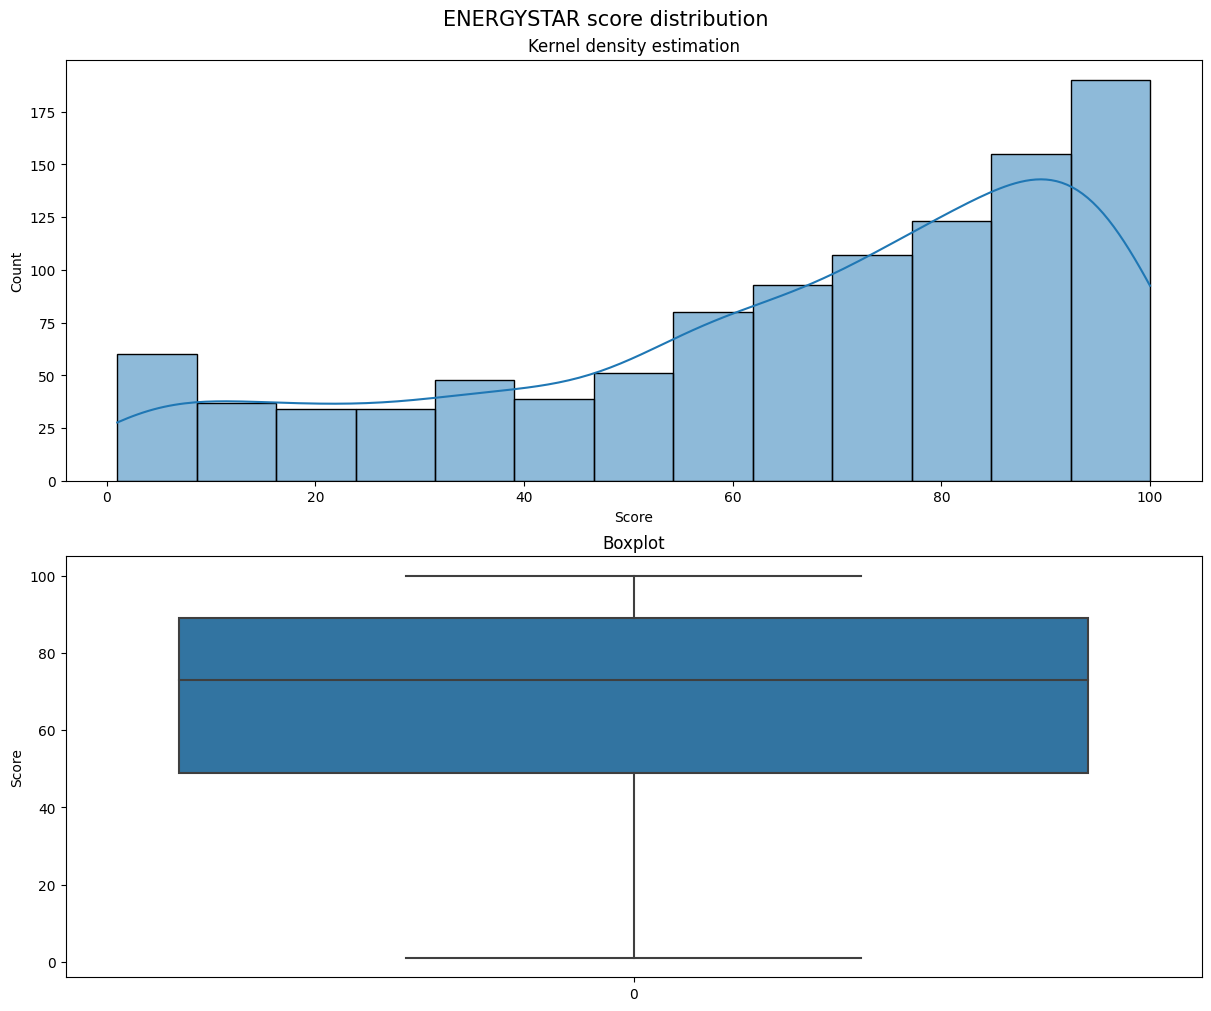

In [78]:
energystar_col = 'ENERGYSTARScore'

fig, ax = plt.subplots(2, 1, figsize=(12, 10), constrained_layout=True)
plt.suptitle("ENERGYSTAR score distribution", fontsize=15)

ax[0].set_title("Kernel density estimation")
ax[0].set_xlabel("Score")
sns.histplot(data=build_df[energystar_col], kde=True, ax=ax[0])

ax[1].set_title("Boxplot")
ax[1].set_ylabel("Score")
sns.boxplot(data=build_df[energystar_col], ax=ax[1])
plt.show()

##### Il y a beaucoup de valeurs manquantes. Je décide d'utiliser la méthode d'imputation KNN pour combler ces valeurs

In [79]:
# Creation d'un nouveau df pour le remplissage
knn_df = build_df.select_dtypes(include=[np.number]).dropna(axis=1, how='all')

# choix du nombre de K
n_neighbors = 6

# Knn imputation
print("KNNImputer avec n_neighbors=" + str(n_neighbors) + "...")
imputer = KNNImputer(n_neighbors=n_neighbors)
knn_df = pd.DataFrame(imputer.fit_transform(knn_df), columns=knn_df.columns)

KNNImputer avec n_neighbors=6...


##### distribution avant et après le remplissage

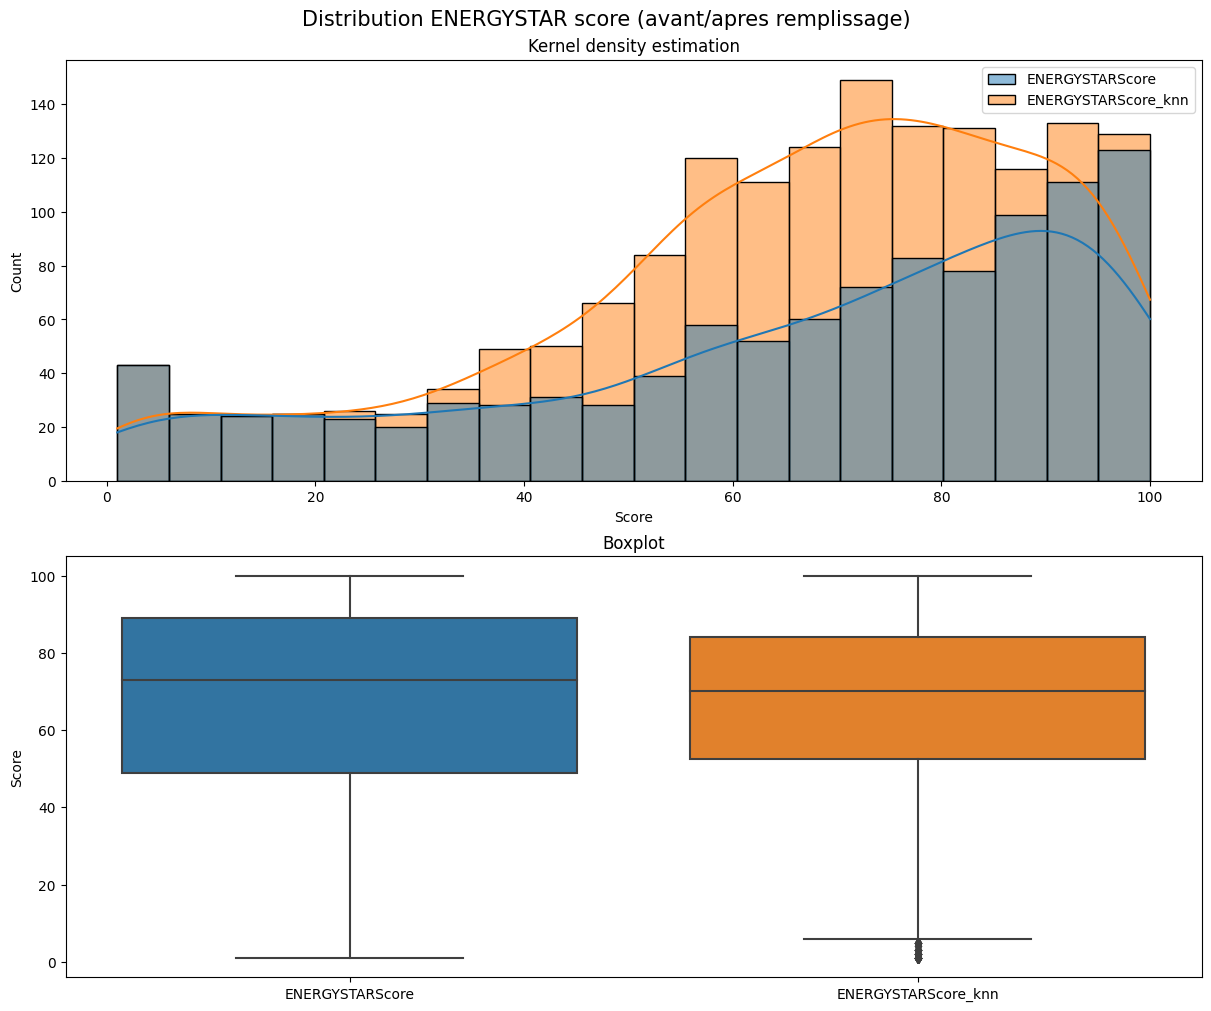

In [80]:
compare_df = pd.concat([build_df[energystar_col], knn_df[energystar_col].rename('ENERGYSTARScore_knn')], axis=1)

fig, ax = plt.subplots(2, 1, figsize=(12, 10), constrained_layout=True)
plt.suptitle("Distribution ENERGYSTAR score (avant/apres remplissage)", fontsize=15)

ax[0].set_title("Kernel density estimation")
ax[0].set_xlabel("Score")
sns.histplot(data=compare_df, kde=True, ax=ax[0])

ax[1].set_title("Boxplot")
ax[1].set_ylabel("Score")
ax[1].set_xlabel("")
sns.boxplot(data=compare_df, ax=ax[1])
plt.show()

##### La distribution après le KNN semble acceptable. Je remplace les valeurs du dataframe originale par les valeurs suivantes

In [81]:
build_df[energystar_col] = knn_df[energystar_col].to_numpy()

print("Valeurs NaN restantes : ", build_df[energystar_col].isna().sum())

Valeurs NaN restantes :  0


## Other variables

In [82]:
# DataYear
print(build_df['DataYear'].unique())

[2016]


##### Il y a uniquement l'annee 2016, je retire cette variable

In [83]:
col_to_remove.append('DataYear')

In [84]:
# ListOfAllPropertyUseTypes
display(build_df['ListOfAllPropertyUseTypes'].value_counts())

ListOfAllPropertyUseTypes
Office                                                                                              138
K-12 School                                                                                         121
Office, Parking                                                                                     120
Non-Refrigerated Warehouse                                                                          101
Non-Refrigerated Warehouse, Office                                                                   61
                                                                                                   ... 
Multifamily Housing, Non-Refrigerated Warehouse, Office, Parking, Retail Store, Worship Facility      1
Data Center, Office, Other, Parking                                                                   1
Bar/Nightclub, Office, Personal Services (Health/Beauty, Dry Cleaning, etc)                           1
Medical Office, Parking, Retail Store 

##### Pas d'interet a conserver cette variable, je la retire

In [85]:
col_to_remove.append('ListOfAllPropertyUseTypes')

In [86]:
# Outliers
display(build_df['Outlier'].value_counts())

Outlier
Low outlier     14
High outlier     2
Name: count, dtype: int64

##### Je ne trouve pas la signification de cette variable, je la retire

In [87]:
col_to_remove.append('Outlier')

In [88]:
# DefaultData
display(build_df['DefaultData'].value_counts())

DefaultData
False    1509
True       87
Name: count, dtype: int64

##### J'affiche les buildings qui contiennent des données par défaut

In [89]:
display(build_df[build_df['DefaultData'] == True])

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,DefaultData,Comments,ComplianceStatus,Outlier,GHGEmissionsIntensity,NewBuildingType,Age,PropertyGFABuildings(log10),SiteEnergyUse(log10),TotalGHGEmissions(log10)
22,28,2016,SPS-District K-12,K-12 School,Graham Hill Elementary,5149 S. Graham St.,Seattle,WA,98118.0,1102000138,...,True,NaN,Error - Correct Default Data,NaN,0.69,Education,55,4.749953,6.187374,1.585799
30,36,2016,SPS-District K-12,K-12 School,Jane Addams Middle,11051 34th Ave. N.E.,Seattle,WA,98125.0,0752000170,...,True,NaN,Error - Correct Default Data,NaN,1.68,Education,67,5.205867,6.831177,2.431653
38,51,2016,SPS-District K-12,K-12 School,Eckstein Middle,3003 N.E. 75th St.,Seattle,WA,98115.0,0425049022,...,True,NaN,Error - Correct Default Data,NaN,1.52,Education,66,5.244438,6.806121,2.424963
86,125,2016,SPS-District K-12,K-12 School,Mercer International Middle,1600 Columbian Way S.,Seattle,WA,98108.0,1624049214,...,True,NaN,Error - Correct Default Data,NaN,1.82,Education,59,5.116814,6.809965,2.377452
87,127,2016,SPS-District K-12,K-12 School,Orca K-8 School,5215 46th Ave. S.,Seattle,WA,98118.0,1704900242,...,True,NaN,Error - Correct Default Data,NaN,0.34,Education,27,4.777825,6.213092,1.311330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3036,27955,2016,SPS-District K-12,K-12 School,Montlake Elementary,2409 22nd Ave. E.,Seattle,WA,98112.0,6788200735,...,True,NaN,Error - Correct Default Data,NaN,1.71,Education,91,4.435733,6.099894,1.669317
3126,39332,2016,SPS-District K-12,K-12 School,South Shore K-8,4800 S. Henderson,Seattle,WA,98118.0,2123700250,...,True,NaN,Error - Correct Default Data,NaN,0.90,Education,7,5.142092,6.695420,2.096110
3366,50210,2016,Nonresidential COS,Office,Central West HQ / Brown Bear,1403 w howe,Seattle,WA,NaN,2425039137,...,True,NaN,Error - Correct Default Data,NaN,0.26,Office,64,4.135482,5.701281,0.544068
3369,50220,2016,Nonresidential COS,Office,Genesee/SC SE HQ,4420 S Genesee,Seattle,WA,NaN,4154300585,...,True,NaN,Error - Correct Default Data,NaN,0.51,Office,56,4.187464,5.588619,0.891537


##### Je decide de retirer cette variable

In [90]:
col_to_remove.append('DefaultData')

In [91]:
# ComplianceStatus
display(build_df['ComplianceStatus'].value_counts())

ComplianceStatus
Compliant                       1495
Error - Correct Default Data      87
Non-Compliant                     14
Name: count, dtype: int64

##### Retrait de cette variable

In [92]:
col_to_remove.append('ComplianceStatus')

In [93]:
# Comments
display(build_df['Comments'].value_counts())

Series([], Name: count, dtype: int64)

##### Cette variable est vide. Je la supprime

In [94]:
col_to_remove.append('Comments')

## Final Cleaning

##### Je commence par supprimer toutes les colonnes indésirables

In [95]:
col_to_remove

['OSEBuildingID',
 'PropertyName',
 'BuildingType',
 'PrimaryPropertyType',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType',
 'City',
 'State',
 'Address',
 'ZipCode',
 'TaxParcelIdentificationNumber',
 'CouncilDistrictCode',
 'YearBuilt',
 'PropertyGFATotal',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseTypeGFA',
 'SiteEUI(kBtu/sf)',
 'SiteEUIWN(kBtu/sf)',
 'SourceEUI(kBtu/sf)',
 'SourceEUIWN(kBtu/sf)',
 'SiteEnergyUseWN(kBtu)',
 'SteamUse(kBtu)',
 'Electricity(kWh)',
 'Electricity(kBtu)',
 'NaturalGas(therms)',
 'NaturalGas(kBtu)',
 'GHGEmissionsIntensity',
 'YearsENERGYSTARCertified',
 'DataYear',
 'ListOfAllPropertyUseTypes',
 'Outlier',
 'DefaultData',
 'ComplianceStatus',
 'Comments']

In [96]:
build_df = build_df.drop(columns=col_to_remove)

# Affiche les colonnes restantes
print("Colonnes restantes apres le nettoyage sont : ")
print(build_df.columns)

Colonnes restantes apres le nettoyage sont : 
Index(['Neighborhood', 'Latitude', 'Longitude', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFAParking', 'ENERGYSTARScore',
       'NewBuildingType', 'Age', 'PropertyGFABuildings(log10)',
       'SiteEnergyUse(log10)', 'TotalGHGEmissions(log10)'],
      dtype='object')


## Cleaning missing data

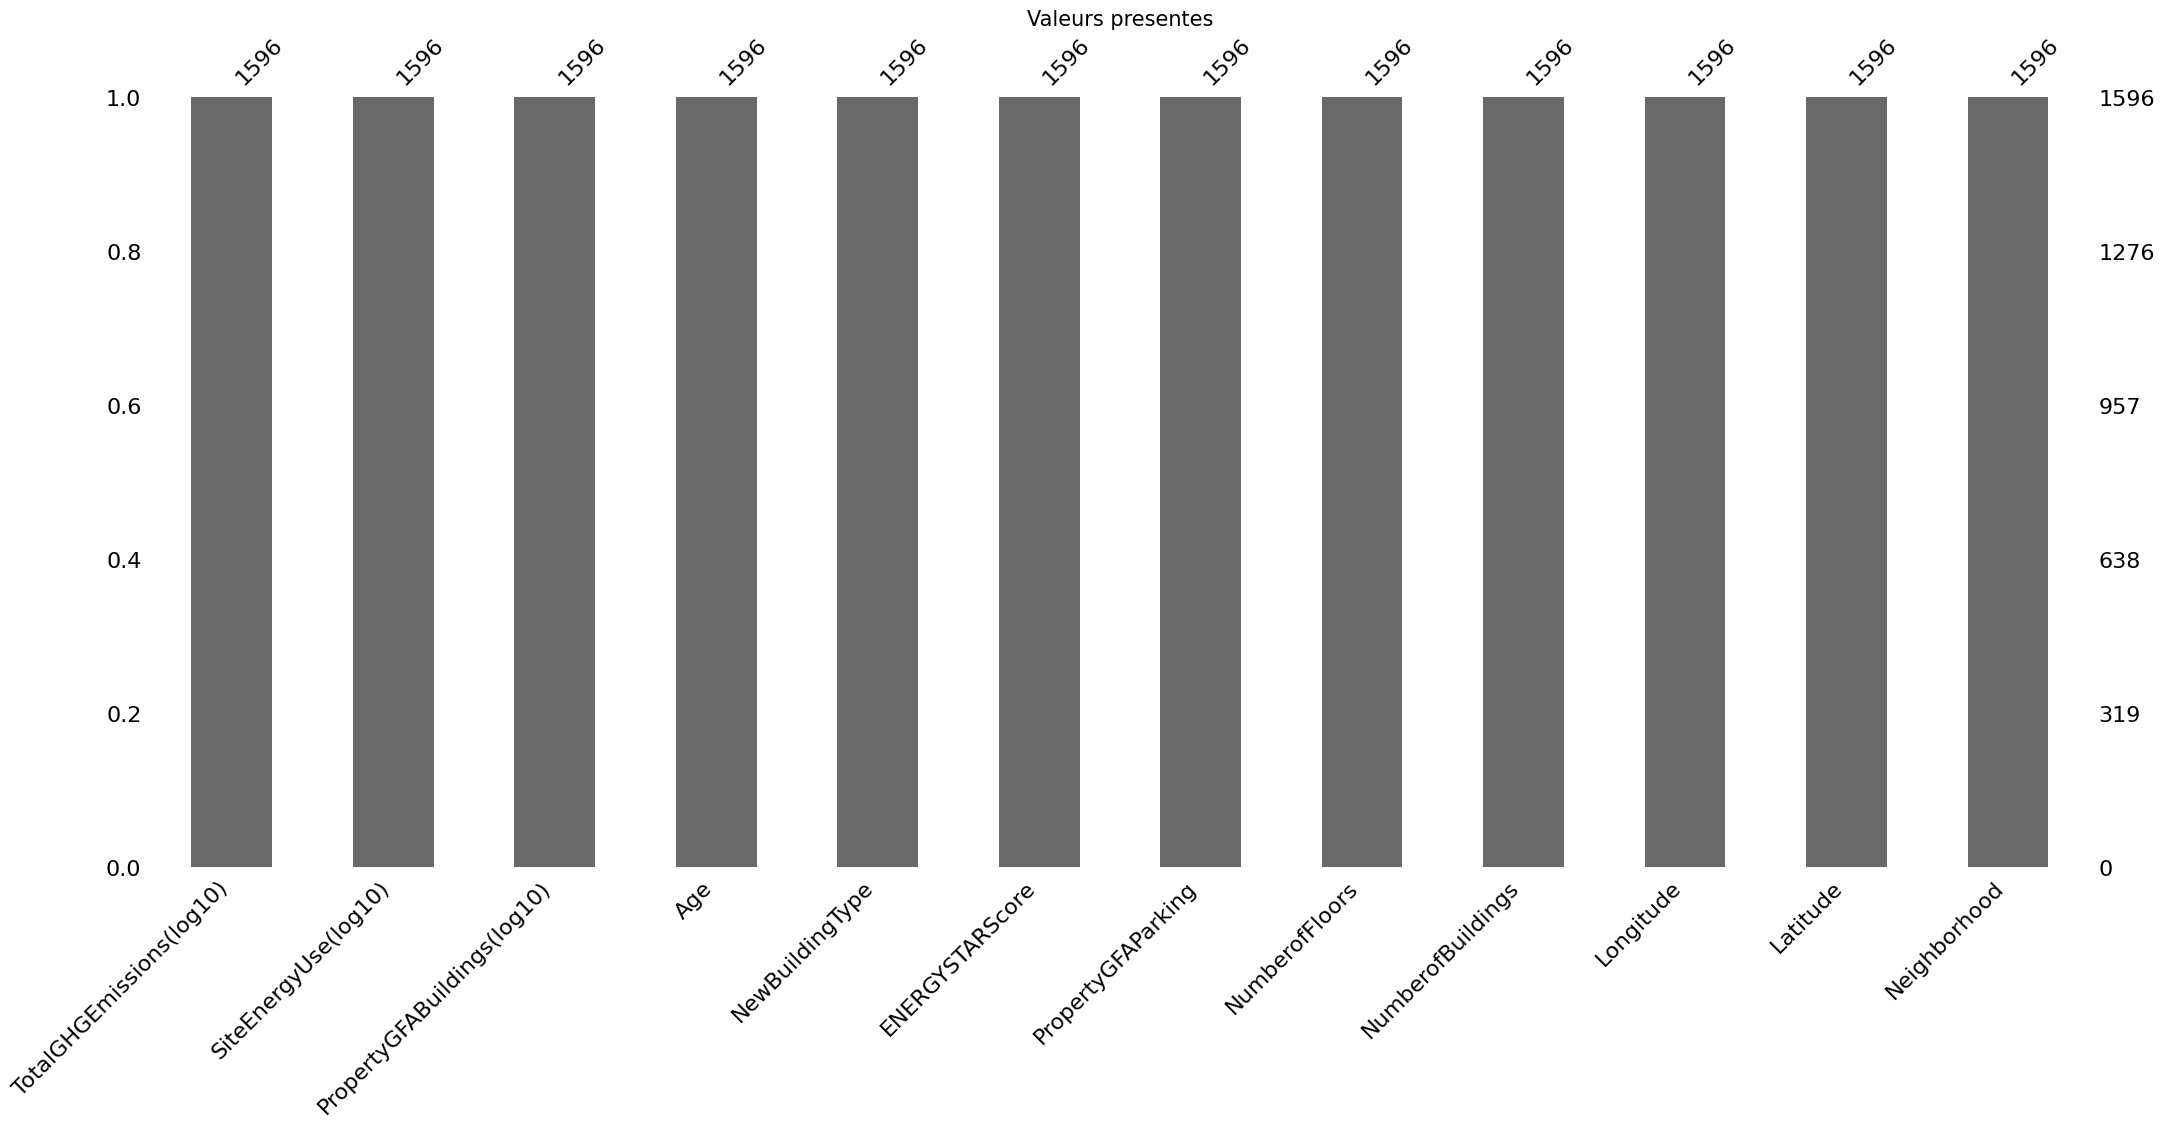

In [97]:
barchart = msno.bar(build_df, sort="descending")
barchart.set_title("Valeurs presentes", fontsize=15)
plt.show()

##### Il n'y a aucune valeur manquante restante

## OHE : One hot encoding

##### Comme les algorithmes d'apprentissage automatique ne fonctionnent pas avec les variables catégorielles, nous utilisons la classe OneHotEncoder de Scikit-Learn pour encoder ces variables en une seule fois

##### Créer de nouvelles variables nominales pour chaque catégorie des variables Neighborhood et NewBuildingType

In [98]:
# Nouveau dataframe avec la convertion des variables categorielle
encoded_df = pd.get_dummies(build_df, prefix=[nbhd_col, 'BuildType'], columns=[nbhd_col, new_type_col])

display(encoded_df.sample(10))

,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFAParking,ENERGYSTARScore,Age,PropertyGFABuildings(log10),SiteEnergyUse(log10),TotalGHGEmissions(log10),...,BuildType_Education,BuildType_Healthcare,BuildType_Hotel,BuildType_Industrial,BuildType_Office,BuildType_Other,BuildType_Religion,BuildType_Restaurant,BuildType_Services,BuildType_Stores
426,47.60613,-122.34115,1,1,0,71.166667,116,4.640760,7.061001,2.786176,...,False,False,False,False,False,False,False,True,False,False
428,47.70759,-122.32550,1,2,0,78.000000,51,5.226907,6.809952,1.959518,...,False,False,False,False,False,False,False,False,False,True
2739,47.71705,-122.28577,1,1,0,90.000000,62,4.334936,5.823922,1.321391,...,False,False,False,False,False,False,True,False,False,False
98,47.66737,-122.37956,4,5,0,14.000000,62,5.455352,7.833088,3.298962,...,False,True,False,False,False,False,False,False,False,False
776,47.66246,-122.29898,1,2,0,82.000000,13,4.698666,6.528558,1.470410,...,False,False,False,False,False,False,False,False,False,True
391,47.54912,-122.32819,1,1,0,63.000000,50,4.745855,5.715841,0.558709,...,False,False,False,True,False,False,False,False,False,False
272,47.60968,-122.33379,1,21,0,58.000000,86,5.485079,7.528008,3.179221,...,False,False,True,False,False,False,False,False,False,False
520,47.62101,-122.36188,1,5,46763,56.000000,8,5.137357,7.171908,2.015234,...,False,False,False,False,True,False,False,False,False,False
692,47.66587,-122.38476,1,3,0,46.000000,37,4.638489,6.507942,1.355068,...,False,False,False,False,True,False,False,False,False,False
372,47.64882,-122.34905,1,4,103032,89.000000,17,5.147064,6.937108,1.929470,...,False,False,False,False,True,False,False,False,False,False


In [99]:
# # target
# 30  SiteEUIWN(kBtu/sf)
# 45  GHGEmissionsIntensity

# ----------------------------------
# # features
# 17  PropertyGFATotal                 3376 non-null   int64  
# 18  PropertyGFAParking               3376 non-null   int64  
# 19  PropertyGFABuilding(s)           3376 non-null   int64  
# 20  ListOfAllPropertyUseTypes        3367 non-null   object 
# 21  LargestPropertyUseType           3356 non-null   object 
# 22  LargestPropertyUseTypeGFA        3356 non-null   float64
# 23  SecondLargestPropertyUseType     1679 non-null   object 
# 24  SecondLargestPropertyUseTypeGFA  1679 non-null   float64
# 25  ThirdLargestPropertyUseType      596 non-null    object 

# 35  SteamUse(kBtu)                   3367 non-null   float64
# 37  Electricity(kBtu)                3367 non-null   float64
# 39  NaturalGas(kBtu)                 3367 non-null   float64

# 35/37/39 a transformer en %
# 35/la somme des 3
# 37/la somme des 3
# 39/la somme des 3